# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from torch.autograd import Variable

import scipy as sc
import statsmodels.api as sm
from pylab import rcParams
import datetime as dt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset, DataLoader, Dataset, TensorDataset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# matplotlib options
import warnings
warnings.filterwarnings('ignore')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=1000)
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
sns.set(rc={"axes.facecolor":"#D3D3D3", "axes.grid":True,'xtick.labelsize':14})

# Data Preparation

In [ ]:
df_m3 = pd.read_csv("/content/drive/MyDrive/Project Deep Learning/Data/Case3/Proj_Measurements_Case3.csv")

In [ ]:
df_nwp3 = pd.read_csv("/content/drive/MyDrive/Project Deep Learning/Data/Case3/Proj_NWP_Case3.csv")

In [ ]:
#Transforming Date_Time column into datetime type
df_nwp3['Date_Time'] = pd.to_datetime(df_nwp3['Date_Time'])
df_m3['Date_Time'] = pd.to_datetime(df_m3['Date_Time'])

In [ ]:
df_m3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118382 entries, 0 to 118381
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date_Time        118382 non-null  datetime64[ns]
 1   Speed_10m        116866 non-null  float64       
 2   Direction_10m    116866 non-null  float64       
 3   Speed_30m        116866 non-null  float64       
 4   Direction_30m    116866 non-null  float64       
 5   Speed_50m        116866 non-null  float64       
 6   Direction_50m    116866 non-null  float64       
 7   Speed_80m        116866 non-null  float64       
 8   Direction_80m    116866 non-null  float64       
 9   Park Power [KW]  117134 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 9.0 MB


In [ ]:
df_nwp3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164094 entries, 0 to 164093
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date_Time          164094 non-null  datetime64[ns]
 1   Direction_10m      164094 non-null  int64         
 2   Speed_10m          164094 non-null  float64       
 3   Temperature_10m    164094 non-null  float64       
 4   Pressure_seaLevel  164094 non-null  float64       
 5   Air Density_10m    164094 non-null  float64       
 6   Direction_50m      164094 non-null  int64         
 7   Speed_50m          164094 non-null  float64       
 8   Temperature_50m    164094 non-null  float64       
 9   Air Density_50m    164094 non-null  float64       
 10  Direction_100m     164094 non-null  int64         
 11  Speed_100m         164094 non-null  float64       
 12  Temperature_100m   164094 non-null  float64       
 13  Air Density_100m   164094 non-null  float64 

In [ ]:
print("The minimum date value of df_nwp3 is: ")
print(min(df_nwp3.Date_Time))
print("The maximum date value of df_nwp3 is:")
print(max(df_nwp3.Date_Time))

The minimum date value of df_nwp3 is: 
2016-01-01 20:00:00
The maximum date value of df_nwp3 is:
2020-09-15 03:15:00


In [ ]:
print("The minimum date value of df_m3 is:")
print(min(df_m3.Date_Time))
print("The maximum date value of df_m3 is:")
print(max(df_m3.Date_Time))

The minimum date value of df_m3 is:
2017-05-01 00:00:00
The maximum date value of df_m3 is:
2020-09-15 03:15:00


Since we're interested in combining both datasets, we will drop the values which are out of the range of our power prediction dataset:

In [ ]:
df_nwp3 = df_nwp3[df_nwp3.Date_Time >= min(df_m3.Date_Time)]

In [ ]:
df_nwp3.head()

Date_Time  Direction_10m  ...  Temperature_150m  Air Density_150m
46576 2017-05-01 00:00:00             89  ...              6.29             1.242
46577 2017-05-01 00:15:00             90  ...              6.20             1.243
46578 2017-05-01 00:30:00             91  ...              6.12             1.243
46579 2017-05-01 00:45:00             92  ...              6.04             1.244
46580 2017-05-01 01:00:00             92  ...              5.97             1.244

[5 rows x 18 columns]

In [ ]:
print("The shape of df_nwp3 is: ", df_nwp3.shape)
print("The shape of df_m3 is: ", df_m3.shape)

The shape of df_nwp3 is:  (117518, 18)
The shape of df_m3 is:  (118382, 10)


In [ ]:
percent_missing = df_m3.isnull().sum() * 100 / len(df_m3)
missing_value_df = pd.DataFrame({'column_name': df_m3.columns,
                                 'percent_missing': percent_missing})
missing_value_df

column_name  percent_missing
Date_Time              Date_Time         0.000000
Speed_10m              Speed_10m         1.280600
Direction_10m      Direction_10m         1.280600
Speed_30m              Speed_30m         1.280600
Direction_30m      Direction_30m         1.280600
Speed_50m              Speed_50m         1.280600
Direction_50m      Direction_50m         1.280600
Speed_80m              Speed_80m         1.280600
Direction_80m      Direction_80m         1.280600
Park Power [KW]  Park Power [KW]         1.054214

In [ ]:
#Getting the series of timestpes where the power data is empty
nopower_dates = df_m3[df_m3["Park Power [KW]"].isnull()].Date_Time
nopower_dates.head(50)

5509    2017-06-27 09:15:00
5510    2017-06-27 09:30:00
5511    2017-06-27 09:45:00
5512    2017-06-27 10:00:00
5513    2017-06-27 10:15:00
5514    2017-06-27 10:30:00
20494   2017-11-30 11:30:00
20498   2017-11-30 12:30:00
20499   2017-11-30 12:45:00
20500   2017-11-30 13:00:00
20501   2017-11-30 13:15:00
22887   2017-12-25 09:45:00
25015   2018-01-16 13:45:00
25016   2018-01-16 14:00:00
25017   2018-01-16 14:15:00
25078   2018-01-17 05:30:00
25079   2018-01-17 05:45:00
25080   2018-01-17 06:00:00
25081   2018-01-17 06:15:00
25082   2018-01-17 06:30:00
25083   2018-01-17 06:45:00
25096   2018-01-17 10:00:00
25131   2018-01-17 18:45:00
25132   2018-01-17 19:00:00
25133   2018-01-17 19:15:00
25134   2018-01-17 19:30:00
25135   2018-01-17 19:45:00
25136   2018-01-17 20:00:00
25137   2018-01-17 20:15:00
25138   2018-01-17 20:30:00
25139   2018-01-17 20:45:00
25140   2018-01-17 21:00:00
25295   2018-01-19 11:45:00
25296   2018-01-19 12:00:00
25297   2018-01-19 12:15:00
25298   2018-01-19 1

In [ ]:
nopower_dates.groupby(by = nopower_dates.dt.date).count()

Date_Time
2017-06-27     6
2017-11-30     5
2017-12-25     1
2018-01-16     3
2018-01-17    17
2018-01-19    17
2018-01-20    16
2018-01-21    13
2018-01-22    10
2018-01-23    29
2018-05-04     1
2018-05-12     1
2018-06-08    11
2018-06-24    27
2018-06-25    62
2018-06-26     1
2018-06-27     6
2018-07-10    11
2018-07-11    12
2018-07-18    48
2018-07-19    31
2018-09-10     1
2018-09-12     7
2018-12-15    10
2018-12-17     1
2019-01-24     8
2019-02-07    15
2019-02-08     2
2019-03-23    11
2019-05-04    10
2019-05-05     3
2019-07-31    11
2019-08-26     3
2019-08-27    61
2019-08-28    96
2019-08-29    96
2019-08-30    96
2019-08-31    96
2019-09-01    77
2019-10-23    51
2019-10-24    96
2019-10-25    96
2019-10-26    56
2019-10-27     3
2019-11-26     1
2020-06-18     2
2020-06-19     7
2020-06-20     4
Name: Date_Time, dtype: int64

In [ ]:
#Lets remove the rows  of df_m3 which have these dates and keep only the Power data column:
df_m3 = df_m3[df_m3["Park Power [KW]"].notna()]
df_m3 = df_m3[["Date_Time", "Park Power [KW]"]]
df_m3.shape

(117134, 2)

In [ ]:
df_merged = df_nwp3.join(df_m3.set_index("Date_Time"), on = "Date_Time", how = 'inner')
df_merged

Date_Time  Direction_10m  ...  Air Density_150m  Park Power [KW]
46576  2017-05-01 00:00:00             89  ...             1.242           3543.0
46577  2017-05-01 00:15:00             90  ...             1.243           2171.0
46578  2017-05-01 00:30:00             91  ...             1.243           2062.0
46579  2017-05-01 00:45:00             92  ...             1.244           2140.0
46580  2017-05-01 01:00:00             92  ...             1.244           1801.0
...                    ...            ...  ...               ...              ...
164089 2020-09-15 02:15:00             92  ...             1.203            805.0
164090 2020-09-15 02:30:00             92  ...             1.204           1506.0
164091 2020-09-15 02:45:00             92  ...             1.204           2345.0
164092 2020-09-15 03:00:00             92  ...             1.204           2499.0
164093 2020-09-15 03:15:00             92  ...             1.205           1731.0

[116270 rows x 19 columns]

In [ ]:
df_merged = df_merged.set_index("Date_Time")
df_merged.head()

Direction_10m  ...  Park Power [KW]
Date_Time                           ...                 
2017-05-01 00:00:00             89  ...           3543.0
2017-05-01 00:15:00             90  ...           2171.0
2017-05-01 00:30:00             91  ...           2062.0
2017-05-01 00:45:00             92  ...           2140.0
2017-05-01 01:00:00             92  ...           1801.0

[5 rows x 18 columns]

In [ ]:
df_merged.describe()

Direction_10m      Speed_10m  ...  Air Density_150m  Park Power [KW]
count   116270.00000  116270.000000  ...     116270.000000    116270.000000
mean       194.67886       3.058887  ...          1.229958     11353.541232
std         87.43854       1.515358  ...          0.069787     12173.730745
min          0.00000       0.000000  ...          1.109000         0.000000
25%        144.00000       2.000000  ...          1.170000      1312.000000
50%        206.00000       2.700000  ...          1.216000      7031.000000
75%        251.00000       3.880000  ...          1.286000     17634.500000
max        359.00000      11.000000  ...          1.432000     49789.000000

[8 rows x 18 columns]

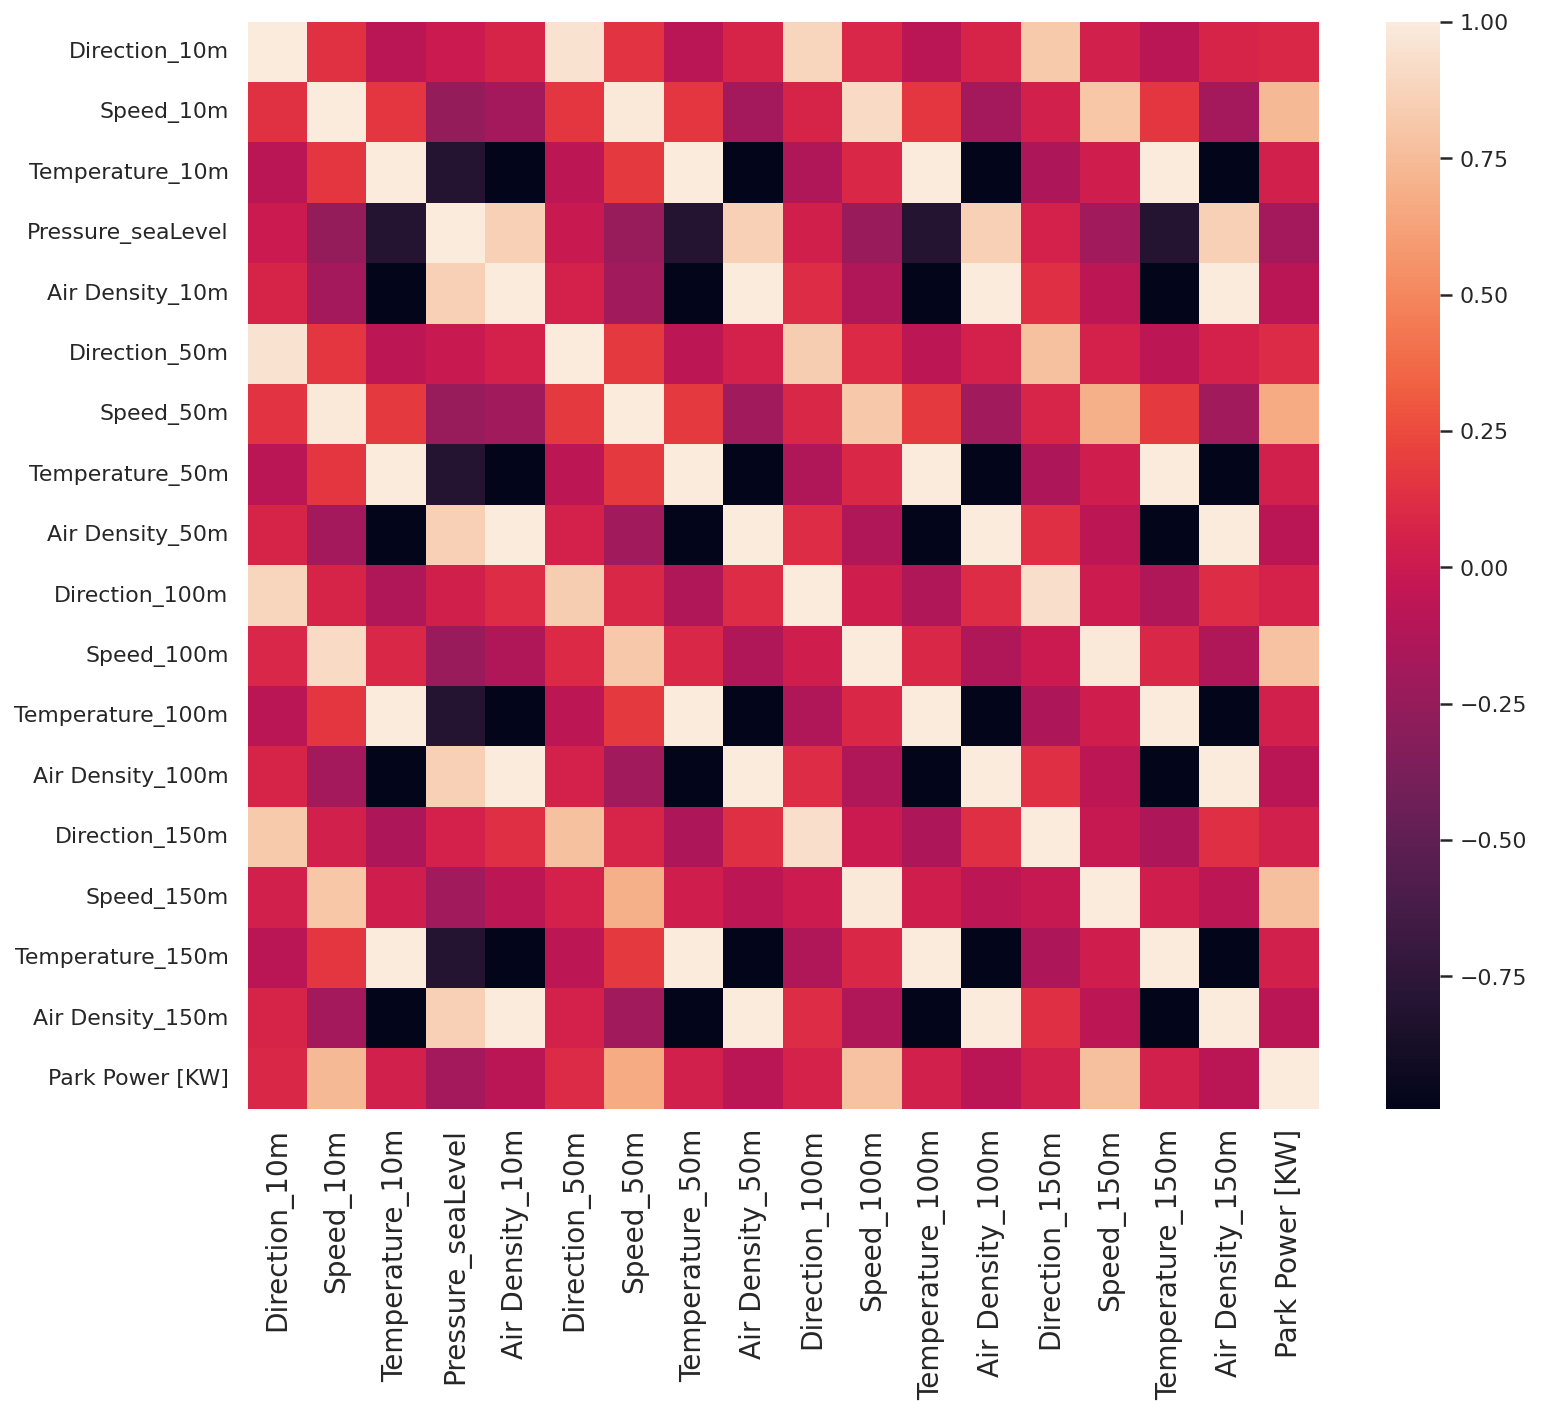

In [ ]:
#Visualizing the correlation matrix
sns.heatmap(df_merged.corr())

## Outlayers Removal

We will visualize the Speed_10m in order to determine what outlayers we will choose to remove

In [ ]:
def whiskers_lines(arr, *args):
  iqr = sc.stats.iqr(arr)
  avg = np.mean(arr)
  q3 = np.percentile(arr, 75)
  q1 = np.percentile(arr, 25)
  low_value = q1-(1.5*iqr)
  high_value = q3+(1.5*iqr)
  print(low_value, high_value)
  avg_line = np.full((116270,), avg)
  low_perc = np.full((116270,), low_value)
  upper_perc = np.full((116270,), high_value)
  return avg_line, low_perc, upper_perc

In [ ]:
speed100 = df_merged["Speed_100m"].values
avg_line, low_perc, upper_perc = whiskers_lines(speed100)

-1.8100000000000005 12.350000000000001


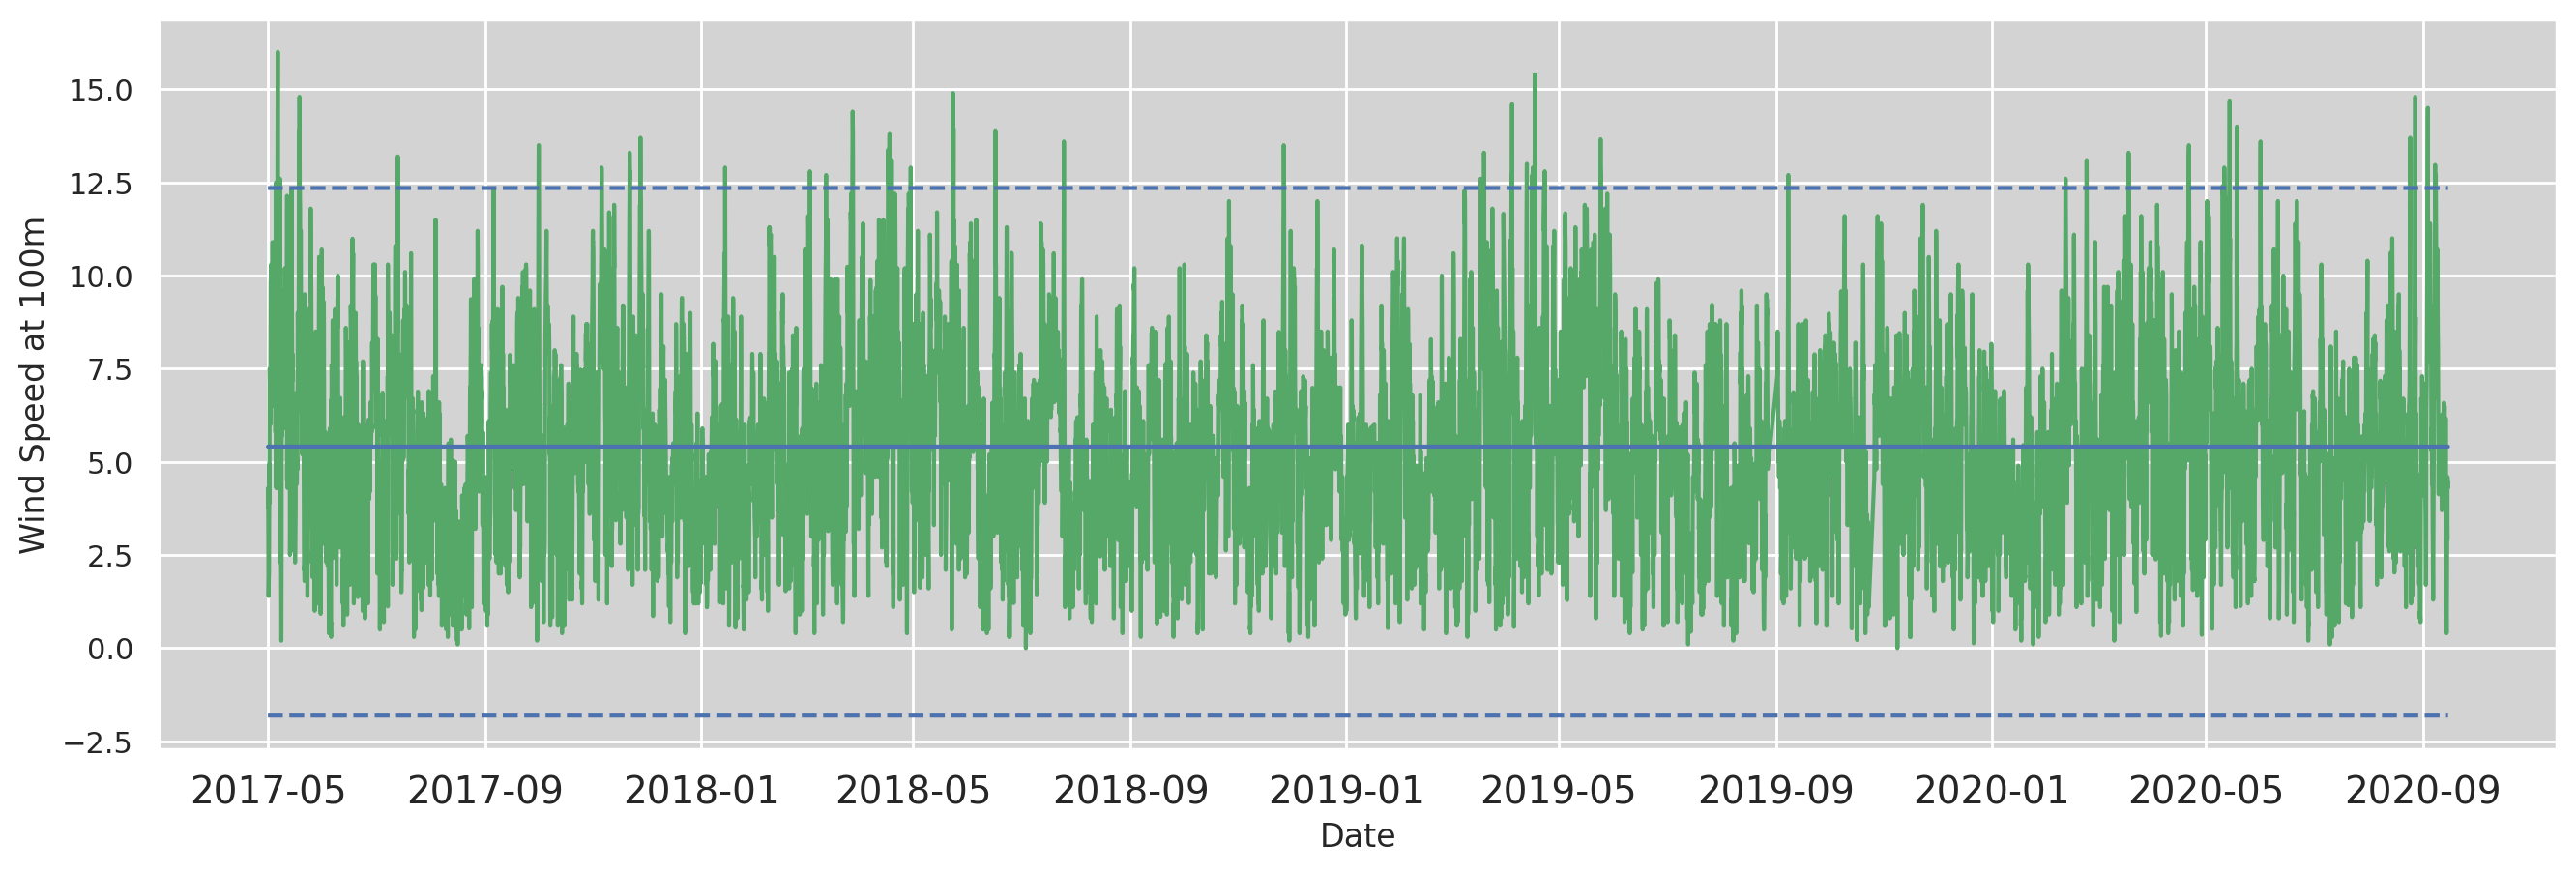

In [ ]:
plt.figure(figsize = (16, 5), dpi = 100)
plt.plot(df_merged.index, df_merged["Speed_100m"], "g")
plt.plot(df_merged.index, avg_line, "b")
plt.plot(df_merged.index, low_perc, "b--")
plt.plot(df_merged.index, upper_perc, "b--")
plt.xlabel("Date")
plt.ylabel("Wind Speed at 100m")
plt.show()

In [ ]:
df_merged["Speed_100m"].quantile(q = 0.997)

13.26

Looking at the graph and by calculating the quantile for the current dataframe, we have decided to drop the values which are above the 0.997 quantile, which theoretically "represent" the [100% of the samples](https://en.wikipedia.org/wiki/68–95–99.7_rule)

In [ ]:
df_merged = df_merged[df_merged.Speed_100m < np.percentile(df_merged.Speed_100m, 99.7)]


In [ ]:
df_merged.describe()

Direction_10m      Speed_10m  ...  Air Density_150m  Park Power [KW]
count   115920.00000  115920.000000  ...     115920.000000    115920.000000
mean       194.61740       3.041419  ...          1.230108     11271.865476
std         87.50251       1.483311  ...          0.069818     12084.090362
min          0.00000       0.000000  ...          1.109000         0.000000
25%        144.00000       2.000000  ...          1.170000      1299.000000
50%        206.00000       2.690000  ...          1.216000      6983.000000
75%        251.00000       3.870000  ...          1.286000     17503.250000
max        359.00000       9.080000  ...          1.432000     49789.000000

[8 rows x 18 columns]

## Data Normalization

In [ ]:
df = (df_merged-df_merged.min())/(df_merged.max() - df_merged.min())
df.head()

Direction_10m  ...  Park Power [KW]
Date_Time                           ...                 
2017-05-01 00:00:00       0.247911  ...         0.071160
2017-05-01 00:15:00       0.250696  ...         0.043604
2017-05-01 00:30:00       0.253482  ...         0.041415
2017-05-01 00:45:00       0.256267  ...         0.042981
2017-05-01 01:00:00       0.256267  ...         0.036173

[5 rows x 18 columns]

Input for the NN done with a function and an object.

In [ ]:
# Pick the attributes needed:
df = df[["Temperature_100m", "Speed_10m", "Speed_100m", "Direction_50m", "Park Power [KW]"]]

In [ ]:
def generate_dataset_fast(df, window_size, deltaLag):
  X = []
  y = []
  for ii in range(0,len(df)-window_size+1):
    sample = df[ii:window_size+ii]
    target = sample["Park Power [KW]"].values[-1]
    success = validate_sample(sample,deltaLag)
    if success is True:
      sample = sample.drop(labels=["Park Power [KW]"], axis=1)
      X.append(sample.values)
      y.append(target)
  return X, y


def validate_sample(sample,deltaLag):
  success = False
  time_diff = sample.index.values[-1]-sample.index.values[0]
  if time_diff == deltaLag:
    success = True
  return success


deltaLag = pd.Timedelta(2, unit='day')
window_size = 193

X, y = generate_dataset_fast(df, window_size, deltaLag)
print(len(X))
print(len(y))

104327
104327


# Predictions

In [ ]:
class hm_Dataset(torch.utils.data.Dataset):
    def __init__(self, xList, labels):
        self.labels = labels
        self.xList = xList

    def __len__(self):
        return len(self.xList)

    def __getitem__(self, index):
        X = self.xList[index]
        y = self.labels[index]

        return X, y

In [ ]:
def reset_weights(m):
  '''
 Reset model weights to avoid leakage of weights
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    layer.reset_parameters()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Load data:
X_trans =[]
for val in X:
  X_trans.append(val.transpose())
print(len(X_trans))
print(X_trans[0].shape)

params = {'batch_size': 6,
          'shuffle': True}

y_trans = y # we do this to avoid spoilt y everytime that we change something (non-meaning step)
print(len(y_trans))
dataset = hm_Dataset(X_trans, y_trans)
# Take the final values for the TEST SET (it can also be done randomly):

test_percent = 0.1 # we keep the 10 % of the data set for testing
X_test_final = X_trans[len(X_trans)-int(np.round(len(X_trans)*test_percent)):-1]
X_trans[len(X_trans)-int(np.round(len(X_trans)*test_percent)):-1] = []
y_test_final = y_trans[len(y_trans)-int(np.round(len(y_trans)*test_percent)):-1]
y_trans[len(y_trans)-int(np.round(len(y_trans)*test_percent)):-1] = []

# Generate TRAIN dataset:
train_dataset = hm_Dataset(X_trans, y_trans)
#print(len(dataset))
# Generate TEST dataset:
test_dataset = hm_Dataset(X_test_final, y_test_final)
#print(len(test_dataset))

104327
(4, 193)
104327


In [ ]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    running_loss =  0.0   # Initialize learning parameters
    err_train = []
    error_per_sample = []
    model.train()
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.type(torch.FloatTensor), labels.type(torch.FloatTensor)
        optimizer.zero_grad() # zero the parameter gradients
        output = model(inputs) # forward + backward + optimize
        batch_loss = criterion(torch.transpose(output, 0 , 1), labels)
        # error_per_sample.append(batch_loss)
        batch_loss = torch.mean(batch_loss)
        batch_loss.backward()
        optimizer.step()
        # train  error: 
        err_train.append(batch_loss.data.detach().numpy())
        running_loss += batch_loss.data.numpy()
        if i % 1000 == 999:  # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    return err_train #, error_per_sample

def test_epoch(model, device, dataloader, loss_fn):
    err_test = []
    abs_diff_test = []
    model.eval()
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.type(torch.FloatTensor), labels.type(torch.FloatTensor)
        output = model(inputs) # forward + backward + optimize
        batch_loss = criterion(torch.transpose(output, 0, 1), labels)
        batch_loss = torch.mean(batch_loss)
        abs_diff = np.mean(np.abs(torch.transpose(output, 0, 1).detach().numpy() - labels.detach().numpy()))
        err_test.append(batch_loss.data.detach().numpy())  #test error
        abs_diff_test.append(abs_diff)
    return err_test, abs_diff_test


In [ ]:
def train_epoch_cuda(model, device, dataloader, loss_fn, optimizer):
    running_loss =  0.0   # Initialize learning parameters
    err_train = []
    error_per_sample = []
    model.train()
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.type(torch.FloatTensor).cuda(), labels.type(torch.FloatTensor).cuda()
        #print(np.shape(inputs))
        optimizer.zero_grad() # zero the parameter gradients
        output = model(inputs) # forward + backward + optimize
        batch_loss = criterion(torch.transpose(output, 0 , 1), labels)
        # error_per_sample.append(batch_loss)
        batch_loss = torch.mean(batch_loss).cuda()
        batch_loss.backward()
        optimizer.step()
        # train  error: 
        err_train.append(batch_loss.cpu().data.detach().numpy())
        running_loss += batch_loss.cpu().data.numpy()
        if i % 1000 == 999:  # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
    return err_train #, error_per_sample

def test_epoch_cuda(model, device, dataloader, loss_fn):
    err_test = []
    abs_diff_test = []
    model.eval()
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.type(torch.FloatTensor).cuda(), labels.type(torch.FloatTensor).cuda()
        output = model(inputs) # forward + backward + optimize
        batch_loss = criterion(torch.transpose(output, 0, 1), labels).cuda()
        batch_loss = torch.mean(batch_loss)
        abs_diff = np.mean(np.abs(torch.transpose(output, 0, 1).cpu().detach().numpy() - labels.cpu().detach().numpy()))
        err_test.append(batch_loss.data.cpu().detach().numpy())  #test error
        abs_diff_test.append(abs_diff)
    return err_test, abs_diff_test


## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.5)
        #self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        # Propagate input through LSTM
        x  = torch.transpose(x, 1 , 2)
        #print(np.shape(x))
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out=self.dropout(h_out)
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        #out=self.sigmoid(out)
        return out




In [ ]:
make_dot(output.cpu(), params=dict(model.named_parameters()), show_attrs=True).render("Complete LSTM Architecture", format="png")

'Complete LSTM Architecture.png'

## CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# CNN parameters:
num_filters_conv1 = 8
num_filters_conv2 = 16
kernel_size_conv1 = 5
kernel_size_conv2 = 5
kernel_size_pooling = 2
padding_conv1 = 2
padding_conv2 = 2
num_l1 = 50
num_l2 = 24


class Net(nn.Module):
    def __init__(self, input_channels):
        super(Net, self).__init__()
        self.input_channels = input_channels

        self.conv1 = nn.Conv1d(in_channels=input_channels,
                               out_channels=num_filters_conv1,
                               kernel_size=kernel_size_conv1,
                               padding=padding_conv1)
        self.pool = nn.MaxPool1d(kernel_size=kernel_size_pooling,
                                 stride=2)
        self.conv2 = nn.Conv1d(in_channels=num_filters_conv1,
                               out_channels=num_filters_conv2,
                               kernel_size=kernel_size_conv2,
                               padding=padding_conv2)

        # set the fully connected layer:
        self.fc1 = nn.Linear(num_filters_conv2*48, num_l1) #*input_channels
        self.fc2 = nn.Linear(num_l1, num_l2)
        self.fc3 = nn.Linear(num_l2, 1)

    def forward(self, x):
        x_cl1 = self.pool(F.relu(self.conv1(x)))
        x_cl2 = self.pool(F.relu(self.conv2(x_cl1)))
        x_flattened = x_cl2.view(-1, num_filters_conv2*48) #*self.input_channels
        x_fc1 = F.relu(self.fc1(x_flattened))
        x_fc2 = F.relu(self.fc2(x_fc1))
        x = self.fc3(x_fc2)

        return x



model = Net(4)
x = torch.randn(6, 4, 193)
print(model(x))

tensor([[0.0862],
        [0.0564],
        [0.0704],
        [0.0722],
        [0.0645],
        [0.0836]], grad_fn=<AddmmBackward0>)


# K-Fold Cross Validation

<font color="red">When reviewing the notebook, we recommend to run alternatively the LSTM and the CNN, otherwise the amount of computing power needed will break the running of the terminal.</font>

In [ ]:
# Start low for troubleshooting purposes
batch_size = 16
k = 5               # Divide the whole period in 5
folds = KFold(n_splits= k, shuffle= True, random_state = 42)
results_cnn = {}
results_lstm = {}


for fold, (train_idx,test_idx) in enumerate(folds.split(np.arange(len(train_dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # ---------------------------------------- CNN training per fold: ------------------------------------------
    # Model:
    num_attributes = 4

    # Create NN:
    model = Net(num_attributes)
    model.apply(reset_weights)

    # Loss Function:
    criterion = nn.MSELoss(reduction='none')
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

    num_epoch = 50

    history = {'train_loss': [], 'test_loss': [], 'abs_diff_train': [], 'abs_diff_test': [], 'train_error_per_epoch': [], 'eval_error_per_epoch': []}
    train_error = []
    eval_error = []
    # sample_error = []
    for epoch in range(num_epoch):
        train_error_epoch = train_epoch(model,device,train_loader,criterion,optimizer)
        eval_loss, eval_abs = test_epoch(model,device,test_loader,criterion) # Evaluate the error of the model generated in each epoch (to check the convergence of the training)
        print("Epoch:{}/{} AVG Training Loss:{:.3f}".format(epoch + 1, num_epoch, np.mean(train_error_epoch)))
        train_error.append(np.mean(train_error_epoch))
        eval_error.append(np.mean(eval_loss))
      

    # Saving the model
    save_path = f'./cnn-model-fold-{fold}.pth'
    torch.save(model.state_dict(), save_path)

    test_loss, test_abs = test_epoch(model,device,test_loader,criterion)
    train_loss, train_abs = test_epoch(model,device,train_loader,criterion)                          
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['abs_diff_train'].append(train_abs)
    history['abs_diff_test'].append(test_abs)
    history['train_error_per_epoch'].append(train_error)
    history['eval_error_per_epoch'].append(eval_error)
    
  

    results_cnn['fold{}'.format(fold+1)] = history  

    # ---------------------------------------- LSTM training per fold: ------------------------------------------
    # Model:
    # add input parameters

    input_size = 4
    hidden_size = 32
    num_layers = 1
    num_classes = 1

    # Create NN:
    lstm_model = LSTM(num_classes, input_size, hidden_size, num_layers).cuda()
    lstm_model.apply(reset_weights)

    # Loss Function:
    criterion = torch.nn.MSELoss(reduction='none')
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0001)

    num_epoch = 50

    history = {'train_loss': [], 'test_loss': [], 'abs_diff_train': [], 'abs_diff_test': [], 'train_error_per_epoch': [], 'eval_error_per_epoch': []} #, 'sample_error': []}
    train_error = []
    eval_error = []

    for epoch in range(num_epoch):
        train_error_epoch = train_epoch_cuda(lstm_model,device,train_loader,criterion,optimizer)
        eval_loss, eval_abs = test_epoch_cuda(lstm_model,device,test_loader,criterion) # Evaluate the error of the model generated in each epoch (to check the convergence of the training)
        print("Epoch:{}/{} AVG Training Loss:{:.3f}".format(epoch + 1, num_epoch, np.mean(train_error_epoch)))
        train_error.append(np.mean(train_error_epoch))
        eval_error.append(np.mean(eval_loss))
        


    # Saving the model
    save_path = f'./lstm-model-fold-{fold}.pth'
    torch.save(lstm_model.state_dict(), save_path)


    test_loss, test_abs = test_epoch(model,device,test_loader,criterion)
    train_loss, train_abs = test_epoch(model,device,train_loader,criterion)
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['abs_diff_train'].append(train_abs)
    history['abs_diff_test'].append(test_abs)
    history['train_error_per_epoch'].append(train_error)
    history['eval_error_per_epoch'].append(eval_error)


    results_lstm['fold{}'.format(fold+1)] = history  

Fold 1
[1,  1000] loss: 0.030
[1,  2000] loss: 0.022
[1,  3000] loss: 0.020
[1,  4000] loss: 0.019
Epoch:1/50 AVG Training Loss:0.022
[2,  1000] loss: 0.018
[2,  2000] loss: 0.019
[2,  3000] loss: 0.019
[2,  4000] loss: 0.018
Epoch:2/50 AVG Training Loss:0.018
[3,  1000] loss: 0.018
[3,  2000] loss: 0.017
[3,  3000] loss: 0.017
[3,  4000] loss: 0.017
Epoch:3/50 AVG Training Loss:0.017
[4,  1000] loss: 0.016
[4,  2000] loss: 0.017
[4,  3000] loss: 0.016
[4,  4000] loss: 0.016
Epoch:4/50 AVG Training Loss:0.016
[5,  1000] loss: 0.016
[5,  2000] loss: 0.016
[5,  3000] loss: 0.016
[5,  4000] loss: 0.015
Epoch:5/50 AVG Training Loss:0.016
[6,  1000] loss: 0.015
[6,  2000] loss: 0.015
[6,  3000] loss: 0.014
[6,  4000] loss: 0.015
Epoch:6/50 AVG Training Loss:0.015
[7,  1000] loss: 0.014
[7,  2000] loss: 0.014
[7,  3000] loss: 0.014
[7,  4000] loss: 0.013
Epoch:7/50 AVG Training Loss:0.014
[8,  1000] loss: 0.013
[8,  2000] loss: 0.013
[8,  3000] loss: 0.013
[8,  4000] loss: 0.012
Epoch:8/50 A

### Tablas Poster

Load CNN results:

In [ ]:
train1, test1, abs_train1, abs_test1, cnn_E_train_epoch1, cnn_E_eval_epoch1 = results_cnn['fold1'].values()
train1, test1, abs_train1, abs_test1, cnn_E_train_epoch1, cnn_E_eval_epoch1 = train1[0], test1[0], abs_train1[0], abs_test1[0], cnn_E_train_epoch1[0], cnn_E_eval_epoch1[0]
train2, test2, abs_train2, abs_test2, cnn_E_train_epoch2, cnn_E_eval_epoch2 = results_cnn['fold2'].values()
train2, test2, abs_train2, abs_test2, cnn_E_train_epoch2, cnn_E_eval_epoch2 = train2[0], test2[0], abs_train2[0], abs_test2[0], cnn_E_train_epoch2[0], cnn_E_eval_epoch2[0]
train3, test3, abs_train3, abs_test3, cnn_E_train_epoch3, cnn_E_eval_epoch3 = results_cnn['fold3'].values()
train3, test3, abs_train3, abs_test3, cnn_E_train_epoch3, cnn_E_eval_epoch3 = train3[0], test3[0], abs_train3[0], abs_test3[0], cnn_E_train_epoch3[0], cnn_E_eval_epoch3[0]
train4, test4, abs_train4, abs_test4, cnn_E_train_epoch4, cnn_E_eval_epoch4 = results_cnn['fold4'].values()
train4, test4, abs_train4, abs_test4, cnn_E_train_epoch4, cnn_E_eval_epoch4 = train4[0], test4[0], abs_train4[0], abs_test4[0], cnn_E_train_epoch4[0], cnn_E_eval_epoch4[0]
train5, test5, abs_train5, abs_test5, cnn_E_train_epoch5, cnn_E_eval_epoch5 = results_cnn['fold5'].values()
train5, test5, abs_train5, abs_test5, cnn_E_train_epoch5, cnn_E_eval_epoch5 = train5[0], test5[0], abs_train5[0], abs_test5[0], cnn_E_train_epoch5[0], cnn_E_eval_epoch5[0]

In [ ]:
# Prepare error measurements:
Park_Cap = 49500

rmse_cnn = []
rmse_cnn.append(np.mean(np.sqrt(test1)))
rmse_cnn.append(np.mean(np.sqrt(test2)))
rmse_cnn.append(np.mean(np.sqrt(test3)))
rmse_cnn.append(np.mean(np.sqrt(test4)))
rmse_cnn.append(np.mean(np.sqrt(test5)))
mse_cnn = []
mse_cnn.append((np.mean(test1)))
mse_cnn.append((np.mean(test2)))
mse_cnn.append((np.mean(test3)))
mse_cnn.append((np.mean(test4)))
mse_cnn.append((np.mean(test5)))
mae_cnn = []
mae_cnn.append((np.mean(abs_test1)))
mae_cnn.append((np.mean(abs_test2)))
mae_cnn.append((np.mean(abs_test3)))
mae_cnn.append((np.mean(abs_test4)))
mae_cnn.append((np.mean(abs_test5)))
capacity_cnn = []
capacity_cnn.append(1 - (np.mean(np.sqrt(test1))/1))
capacity_cnn.append(1 - (np.mean(np.sqrt(test2))/1))
capacity_cnn.append(1 - (np.mean(np.sqrt(test3))/1))
capacity_cnn.append(1 - (np.mean(np.sqrt(test4))/1))
capacity_cnn.append(1 - (np.mean(np.sqrt(test5))/1))

Load LSTM results:

In [ ]:
train1, test1, abs_train1, abs_test1, lstm_E_train_epoch1, lstm_E_eval_epoch1 = results_lstm['fold1'].values()
train1, test1, abs_train1, abs_test1, lstm_E_train_epoch1, lstm_E_eval_epoch1 = train1[0], test1[0], abs_train1[0], abs_test1[0], lstm_E_train_epoch1[0], lstm_E_eval_epoch1[0]
train2, test2, abs_train2, abs_test2, lstm_E_train_epoch2, lstm_E_eval_epoch2 = results_lstm['fold2'].values()
train2, test2, abs_train2, abs_test2, lstm_E_train_epoch2, lstm_E_eval_epoch2 = train2[0], test2[0], abs_train2[0], abs_test2[0], lstm_E_train_epoch2[0], lstm_E_eval_epoch2[0]
train3, test3, abs_train3, abs_test3, lstm_E_train_epoch3, lstm_E_eval_epoch3 = results_lstm['fold3'].values()
train3, test3, abs_train3, abs_test3, lstm_E_train_epoch3, lstm_E_eval_epoch3 = train3[0], test3[0], abs_train3[0], abs_test3[0], lstm_E_train_epoch3[0], lstm_E_eval_epoch3[0]
train4, test4, abs_train4, abs_test4, lstm_E_train_epoch4, lstm_E_eval_epoch4 = results_lstm['fold4'].values()
train4, test4, abs_train4, abs_test4, lstm_E_train_epoch4, lstm_E_eval_epoch4 = train4[0], test4[0], abs_train4[0], abs_test4[0], lstm_E_train_epoch4[0], lstm_E_eval_epoch4[0]
train5, test5, abs_train5, abs_test5, lstm_E_train_epoch5, lstm_E_eval_epoch5 = results_lstm['fold5'].values()
train5, test5, abs_train5, abs_test5, lstm_E_train_epoch5, lstm_E_eval_epoch5 = train5[0], test5[0], abs_train5[0], abs_test5[0], lstm_E_train_epoch5[0], lstm_E_eval_epoch5[0]

In [ ]:
# Prepare measuremts:
rmse_lstm = []
rmse_lstm.append(np.mean(np.sqrt(test1)))
rmse_lstm.append(np.mean(np.sqrt(test2)))
rmse_lstm.append(np.mean(np.sqrt(test3)))
rmse_lstm.append(np.mean(np.sqrt(test4)))
rmse_lstm.append(np.mean(np.sqrt(test5)))
mse_lstm = []
mse_lstm.append((np.mean(test1)))
mse_lstm.append((np.mean(test2)))
mse_lstm.append((np.mean(test3)))
mse_lstm.append((np.mean(test4)))
mse_lstm.append((np.mean(test5)))
mae_lstm = []
mae_lstm.append((np.mean(abs_test1)))
mae_lstm.append((np.mean(abs_test2)))
mae_lstm.append((np.mean(abs_test3)))
mae_lstm.append((np.mean(abs_test4)))
mae_lstm.append((np.mean(abs_test5)))
capacity_lstm = []
capacity_lstm.append(1 - (np.mean(np.sqrt(test1))/1))
capacity_lstm.append(1 - (np.mean(np.sqrt(test2))/1))
capacity_lstm.append(1 - (np.mean(np.sqrt(test3))/1))
capacity_lstm.append(1 - (np.mean(np.sqrt(test4))/1))
capacity_lstm.append(1 - (np.mean(np.sqrt(test5))/1))

Comparing errors per fold: CNN vs. LSTM

In [ ]:
# RESULTS (matrix of erros comparing CNN and LSTM per fold to put in the paper -> out of this matrix maybe we can do a statistical analysis):
print('RMSE CNN:')
print((rmse_cnn))
print('RMSE LSTM:')
print((rmse_lstm))
print('MSE CNN:')
print((mse_cnn))
print('MSE LSTM:')
print((mse_lstm))
print('MAE CNN:')
print((mae_cnn))
print('MAE LSTM:')
print((mae_lstm))
print('Capacity CNN:')
print((capacity_cnn))
print('Capacity LSTM:')
print((capacity_lstm))

RMSE CNN:
[0.06523361, 0.061425213, 0.06334056, 0.06310302, 0.062996335]
RMSE LSTM:
[0.0, 0.0, 0.0, 0.0, 0.0]
MSE CNN:
[0.004255424, 0.003773057, 0.004012027, 0.0039819907, 0.0039685383]
MSE LSTM:
[0.0, 0.0, 0.0, 0.0, 0.0]
MAE CNN:
[0.047008045, 0.0446716, 0.045736592, 0.046234917, 0.0449627]
MAE LSTM:
[0.0, 0.0, 0.0, 0.0, 0.0]
Capacity CNN:
[0.9997067967303509, 0.9997239141949368, 0.9997153053443588, 0.999716373031311, 0.99971685252974]
Capacity LSTM:
[1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
rmse_CNN = [0.06523361, 0.061425213, 0.06334056, 0.06310302, 0.062996335]
rmse_LSTM = [0.13524456, 0.13577527, 0.13334517, 0.13401046, 0.13318762]

capacity_lstm = (1 - (rmse_LSTM/Park_Cap))*100
capacity_cnn = (1 - (rmse_CNN/Park_Cap))*100

In [ ]:
data = {
    "rmse_CNN":[0.06523361, 0.061425213, 0.06334056, 0.06310302, 0.062996335],
    "rmse_LSTM": [0.13524456, 0.13577527, 0.13334517, 0.13401046, 0.13318762],
    "mse_CNN": [0.004255424, 0.003773057, 0.004012027, 0.0039819907, 0.0039685383],
    "mse_LSTM": [0.018330887, 0.018465405, 0.017821735, 0.017994665, 0.017793361],
    "mae_CNN": [0.047008045, 0.0446716, 0.045736592, 0.046234917, 0.0449627],
    "mae_LSTM" :[0.09368053, 0.093597926, 0.09287594, 0.09298259, 0.09237877],
    "capacity_CNN": [93.476639, 93.8574787, 93.665944, 93.68969799999999, 93.7003665],
    "capacity_LSTM": [86.475544, 86.422473, 86.665483, 86.59895399999999, 86.68123800000001]}
cv_df =pd.DataFrame(data)
cv_df.head(6)

rmse_CNN  rmse_LSTM   mse_CNN  ...  mae_LSTM  capacity_CNN  capacity_LSTM
0  0.065234   0.135245  0.004255  ...  0.093681     93.476639      86.475544
1  0.061425   0.135775  0.003773  ...  0.093598     93.857479      86.422473
2  0.063341   0.133345  0.004012  ...  0.092876     93.665944      86.665483
3  0.063103   0.134010  0.003982  ...  0.092983     93.689698      86.598954
4  0.062996   0.133188  0.003969  ...  0.092379     93.700367      86.681238

[5 rows x 8 columns]

### Best models (fold)

Look for the best CNN model and test it:

In [ ]:
# We use MSE to decide the best model:
min_cnn_err = min(mse_cnn)
min_cnn_err_index = mse_cnn.index(min_cnn_err)
print('Modelo optimo CNN:')
print(min_cnn_err_index)

# -------  Load the best model: -----------------------
final_test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model:
num_attributes = 4

# Create NN:
model = Net(num_attributes)
PATH = f'./cnn-model-fold-{min_cnn_err_index}.pth'
model.load_state_dict(torch.load(PATH))
model.eval()

# Loss Function:
criterion = nn.MSELoss(reduction='none')

# Test the model:
CNN_prediction = []
CNN_target = []  
for i, data in enumerate(final_test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.type(torch.FloatTensor), labels.type(torch.FloatTensor)
    output = model(inputs) # forward + backward + optimize
    CNN_target.append(labels)
    CNN_prediction.append(output)


Modelo optimo CNN:
1


Look for the best LSTM model and test it:

In [ ]:
# We use MSE to decide the best model:
min_lstm_err = min(mse_lstm)
min_lstm_err_index = mse_lstm.index(min_lstm_err)
print('Modelo optimo LSTM:')
print(min_lstm_err_index)

# -------  Load the best model: -----------------------
final_test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model:
input_size = 4
hidden_size = 32
num_layers = 1
num_classes = 1
# Create NN:
model = LSTM(num_classes, input_size, hidden_size, num_layers).cuda()
PATH = f'./lstm-model-fold-{min_lstm_err_index}.pth'
model.load_state_dict(torch.load(PATH))
model.eval()

# Loss Function:
criterion = 'criterion'

# Test the model:
LSTM_prediction = []
LSTM_target = []  
for i, data in enumerate(final_test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.type(torch.FloatTensor), labels.type(torch.FloatTensor)
    output = model(inputs) # forward + backward + optimize
    LSTM_target.append(labels)
    LSTM_prediction.append(output)

In [ ]:
########################################################################################
########     Extract actual Power, predicted Power of the optimal model (1)     ########
########################################################################################

#   CNN

cnn_target_stacked = torch.stack(CNN_target).detach().numpy()
cnn_target_stacked = cnn_target_stacked.tolist()
cnn_target_list = []
for n in range(len(cnn_target_stacked)):
  cnn_target_list.extend(cnn_target_stacked[n])

cnn_prediction_stacked = torch.stack(CNN_prediction).detach().numpy()
cnn_prediction_stacked = cnn_prediction_stacked.tolist()
cnn_prediction_list = []
for n in ((cnn_prediction_stacked)):
  for i in (n):
      cnn_prediction_list.extend(i)
cnn_prediction_list = np.array(cnn_prediction_list)
cnn_prediction_list = np.clip(cnn_prediction_list, 0,1)
cnn_prediction_list=cnn_prediction_list.flatten().tolist()

print("Type of targets: " + str(type(cnn_target_list[0])))
print("Type of predictions: " + str(type(cnn_prediction_list[0])))

#   LSTM

lstm_target_stacked = torch.stack(LSTM_target).detach().numpy()
lstm_target_stacked = lstm_target_stacked.tolist()
lstm_target_list = []
for n in range(len(lstm_target_stacked)):
  lstm_target_list.extend(lstm_target_stacked[n])

lstm_prediction_stacked = torch.stack(CNN_prediction).detach().numpy()
lstm_prediction_stacked = lstm_prediction_stacked.tolist()
lstm_prediction_list = []
for n in ((lstm_prediction_stacked)):
  for i in (n):
      lstm_prediction_list.extend(i)
lstm_prediction_list = np.array(lstm_prediction_list)
lstm_prediction_list = np.clip(lstm_prediction_list, 0,1)
lstm_prediction_list=lstm_prediction_list.flatten().tolist()

print("Type of targets: " + str(type(lstm_target_list[0])))
print("Type of predictions: " + str(type(lstm_prediction_list[0])))

Type of targets: <class 'float'>
Type of predictions: <class 'float'>


### Plots

Plots of K-fold CV (we look for the best model, test it with the test set kept apart and plot the results of the prediction). We also plot the trainig vs. evaluation plot, and the MSE point by point of the optimal model:

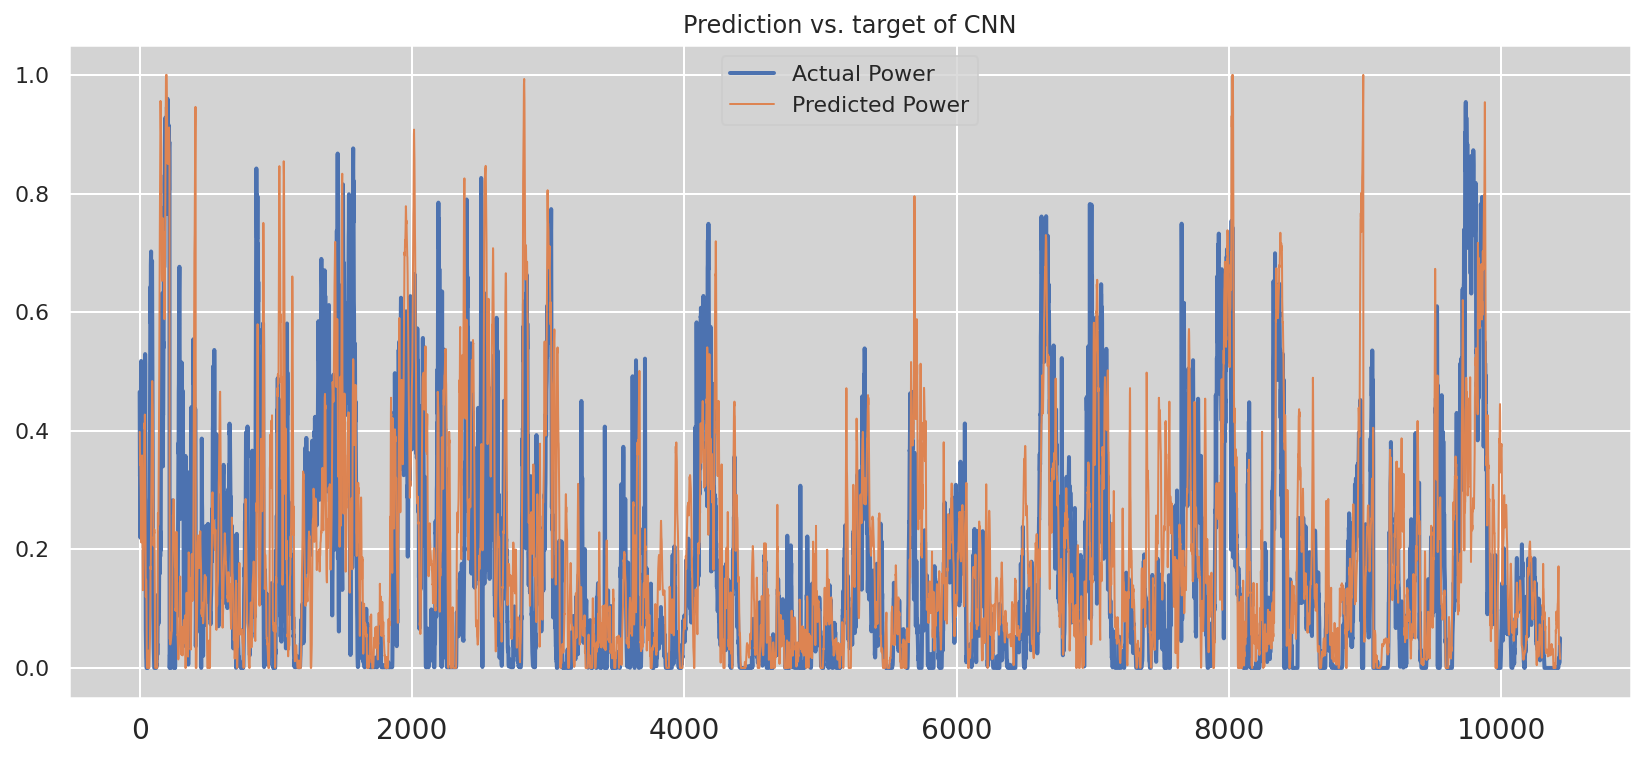

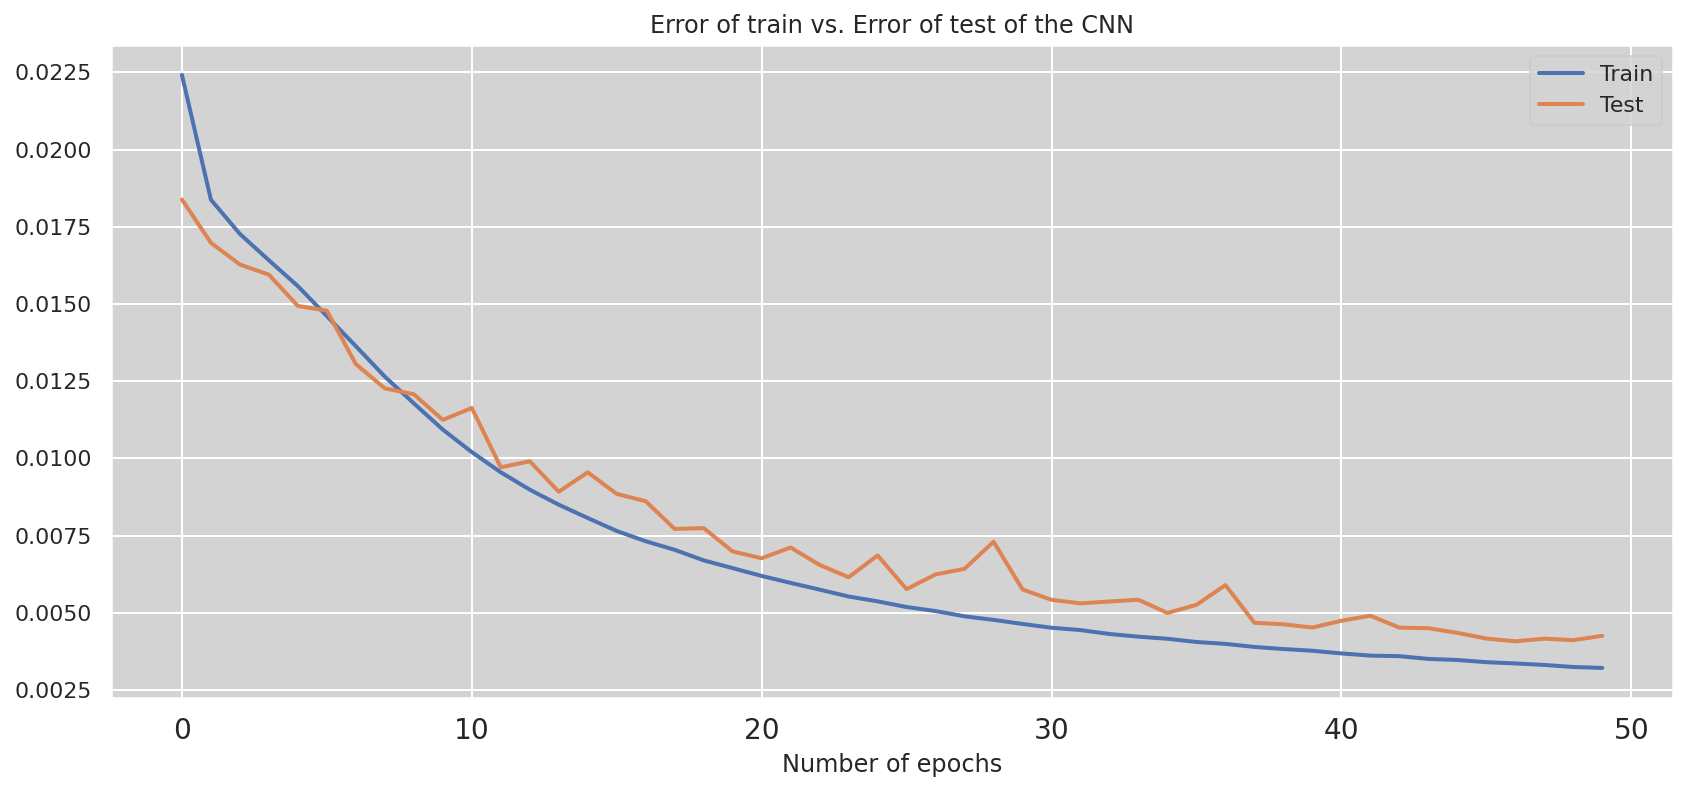

In [ ]:
# --------------------- CNN plots: ---------------------------------------
# Plot of prediction of the optimal model with the test set:
# variables: 'CNN_prediction' vs 'CNN_target'
plt.figure(figsize=(14,6))
sns.lineplot(data=cnn_target_list, label = "Actual Power", linewidth = 2)
sns.lineplot(data=cnn_prediction_list, label = "Predicted Power", linewidth = 1)
plt.title("Prediction vs. target of CNN")
plt.show()




# Plot of the error train and validation of the optimal model:
# variables: 'cnn_E_train_epoch1' vs. 'cnn_E_eval_epoch1' (the number, 1 in this case, should correspond to the optimal model)
plt.figure(figsize=(14,6))
sns.lineplot(data= cnn_E_train_epoch1, linewidth = 2, label = "Train")
sns.lineplot(data=cnn_E_eval_epoch1 , linewidth = 2, label = "Test")
plt.title("Error of train vs. Error of test of the CNN")
plt.xlabel("Number of epochs")
plt.xticks
plt.show()





# # --------------------- LSTM plots: ---------------------------------------
# # Plot of prection of the optimal model with the test set:
# # variables: 'LSTM_prediction' vs 'LSTM_target'
plt.figure(figsize=(14,6))
sns.lineplot(data=lstm_target_list, label = "Actual Power", linewidth = 2)
sns.lineplot(data=lstm_prediction_list, label = "Predicted Power", linewidth = 1)
plt.title("Prediction vs. target of LSTM")
plt.show()





# # Plot of the error train and validation of the optimal model:
# # variables: 'lstm_E_train_epoch1' vs. 'lstm_E_eval_epoch1' (the number, 1 in this case, should correspond to the optimal model)
plt.figure(figsize=(14,6))
sns.lineplot(data= lstm_E_train_epoch1, linewidth = 2, label = "Train")
sns.lineplot(data=lstm_E_eval_epoch1 , linewidth = 2, label = "Test")
plt.title("Error of train vs. Error of test of the LSTM")
plt.xlabel("Number of epochs")
plt.xticks
plt.show()

# K-Fold Cross Validation Temporal for CNN

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Start low for troubleshooting purposes
num_epoch = 150
batch_size = 16
k = 4
folds = KFold(n_splits= k)

window_size = []
err_test = []

win_len = 10000
for jj in range(1,10):
  window_size.append(win_len)
  win_len = win_len + 10000

idx_ini_test = 93895
test_idx = np.arange(idx_ini_test,104327)
count = 1

for ii in window_size:
    print(count)
    count = count + 1
    train_idx = np.arange(idx_ini_test - ii,idx_ini_test)

    train_sampler = torch.utils.data.sampler.SequentialSampler(train_idx)
    test_sampler = torch.utils.data.sampler.SequentialSampler(test_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Model:
    num_attributes = 4

    # Create NN:
    model = Net(num_attributes)
    model.apply(reset_weights)

    # Loss Function:
    criterion = nn.MSELoss(reduction='none')
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

    for epoch in range(num_epoch):
        train_error_epoch = train_epoch(model,device,train_loader,criterion,optimizer)
        print("Epoch:{}/{} AVG Training Loss:{:.3f}".format(epoch + 1, num_epoch, np.mean(train_error_epoch)))

    err_test_epoch = []
    model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.type(torch.FloatTensor), labels.type(torch.FloatTensor)
        output = model(inputs) # forward + backward + optimize
        batch_loss = criterion(torch.transpose(output, 0, 1), labels)
        batch_loss = torch.mean(batch_loss)
        err_test_epoch.append(batch_loss.data.detach().numpy())  #test error
    err_test.append(np.mean(err_test_epoch))
        
        

1
Epoch:1/150 AVG Training Loss:0.033
Epoch:2/150 AVG Training Loss:0.033
Epoch:3/150 AVG Training Loss:0.031
Epoch:4/150 AVG Training Loss:0.026
Epoch:5/150 AVG Training Loss:0.024
Epoch:6/150 AVG Training Loss:0.023
Epoch:7/150 AVG Training Loss:0.022
Epoch:8/150 AVG Training Loss:0.021
Epoch:9/150 AVG Training Loss:0.020
Epoch:10/150 AVG Training Loss:0.020
Epoch:11/150 AVG Training Loss:0.019
Epoch:12/150 AVG Training Loss:0.018
Epoch:13/150 AVG Training Loss:0.018
Epoch:14/150 AVG Training Loss:0.017
Epoch:15/150 AVG Training Loss:0.017
Epoch:16/150 AVG Training Loss:0.016
Epoch:17/150 AVG Training Loss:0.016
Epoch:18/150 AVG Training Loss:0.015
Epoch:19/150 AVG Training Loss:0.015
Epoch:20/150 AVG Training Loss:0.014
Epoch:21/150 AVG Training Loss:0.014
Epoch:22/150 AVG Training Loss:0.013
Epoch:23/150 AVG Training Loss:0.013
Epoch:24/150 AVG Training Loss:0.013
Epoch:25/150 AVG Training Loss:0.012
Epoch:26/150 AVG Training Loss:0.011
Epoch:27/150 AVG Training Loss:0.010
Epoch:28

Error for each of the window sizes:

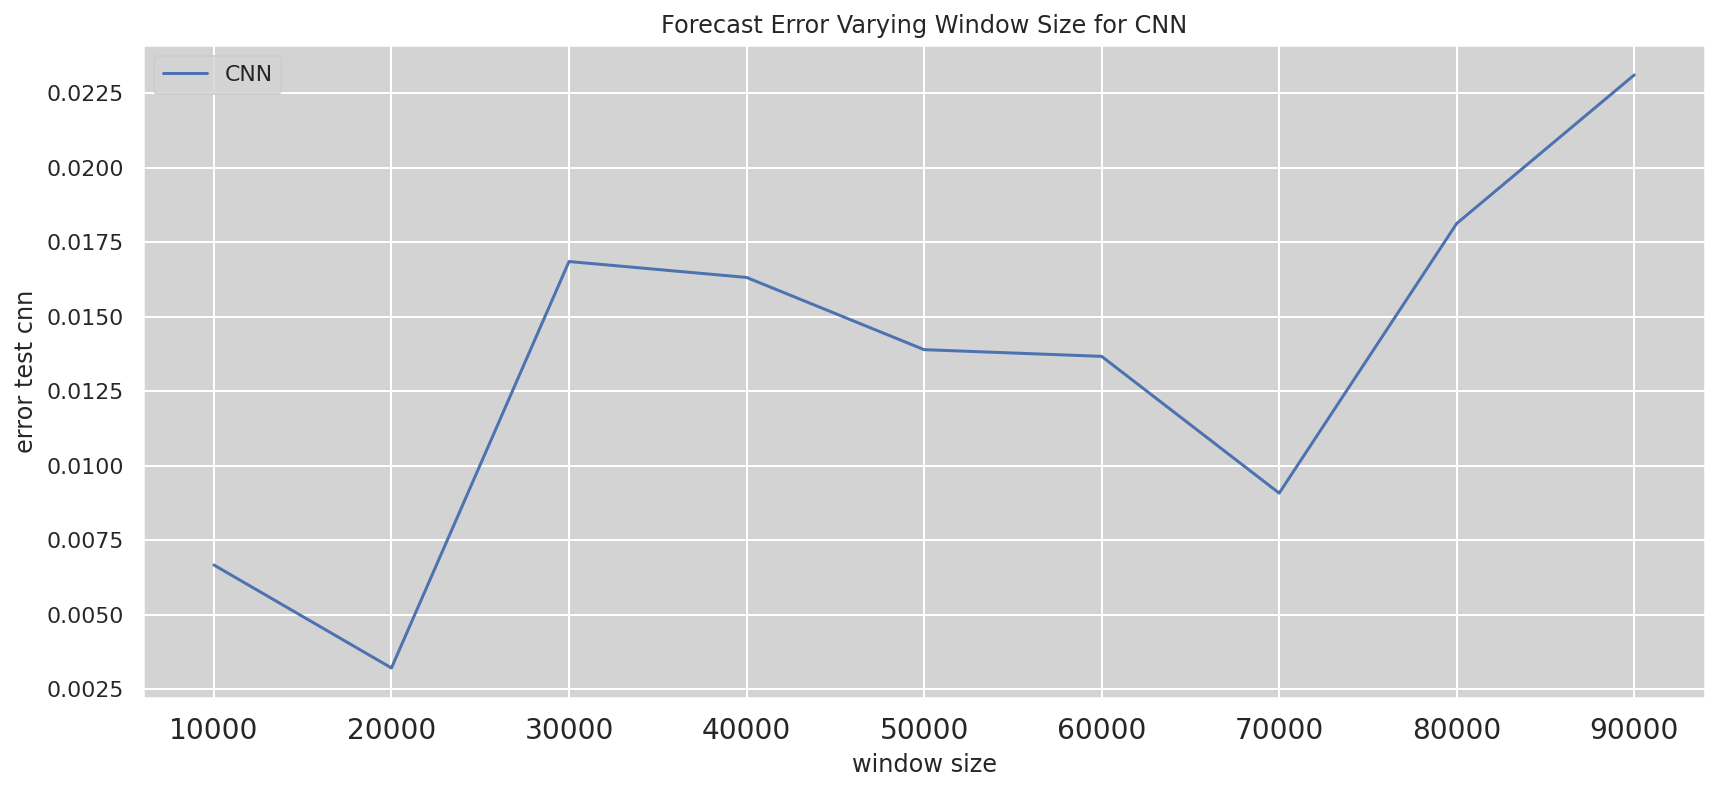

In [ ]:
data = zip(window_size, err_test)
df= pd.DataFrame(data =data, columns = ["window size", "error test cnn"])
plt.figure(figsize=(14,6))
plt.title("Forecast Error Varying Window Size for CNN")
sns.lineplot(x = df["window size"], y = df["error test cnn"], label = "CNN")

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Start low for troubleshooting purposes
num_epoch = 150
batch_size = 16
k = 4
folds = KFold(n_splits= k)

prediction_temp_CNN_1 = []
prediction_temp_CNN_2 = []
prediction_temp_CNN_3 = []
prediction_temp_CNN_4 = []
err_test_1 = []
err_test_2 = []
err_test_3 = []
err_test_4 = []
target_temp_CNN = []

for fold, (train_idx,test_idx) in enumerate(folds.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold + 1))
    test_idx = np.arange(83461,104327)
    if fold == 0:
      train_idx = np.arange(62595,83461)
    elif fold == 1:
      train_idx = np.arange(41730,83461)
    elif fold == 2:
      train_idx = np.arange(20865,83461)
    elif fold == 3:
      train_idx = np.arange(0,83461)
    else:
      break

    train_sampler = torch.utils.data.sampler.SequentialSampler(train_idx)
    test_sampler = torch.utils.data.sampler.SequentialSampler(test_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Model:
    num_attributes = 4

    # Create NN:
    model = Net(num_attributes)
    model.apply(reset_weights)

    # Loss Function:
    criterion = nn.MSELoss(reduction='none')
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 

    for epoch in range(num_epoch):
        train_error_epoch = train_epoch(model,device,train_loader,criterion,optimizer)
        print("Epoch:{}/{} AVG Training Loss:{:.3f}".format(epoch + 1, num_epoch, np.mean(train_error_epoch)))

    model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.type(torch.FloatTensor), labels.type(torch.FloatTensor)
        output = model(inputs) # forward + backward + optimize
        batch_loss = criterion(torch.transpose(output, 0, 1), labels)
        batch_loss = torch.mean(batch_loss)
        if fold == 0:
          prediction_temp_CNN_1.append(output)
          err_test_1.append(batch_loss.data.detach().numpy())  #test error
          target_temp_CNN.append(labels)
        elif fold == 1:
          prediction_temp_CNN_2.append(output)
          err_test_2.append(batch_loss.data.detach().numpy())  #test error
        elif fold == 2:
          prediction_temp_CNN_3.append(output)
          err_test_3.append(batch_loss.data.detach().numpy())  #test error
        elif fold == 3:
          prediction_temp_CNN_4.append(output)
          err_test_4.append(batch_loss.data.detach().numpy())  #test error
        

Fold 1
[1,  1000] loss: 0.037
Epoch:1/150 AVG Training Loss:0.038
[2,  1000] loss: 0.030
Epoch:2/150 AVG Training Loss:0.029
[3,  1000] loss: 0.025
Epoch:3/150 AVG Training Loss:0.025
[4,  1000] loss: 0.024
Epoch:4/150 AVG Training Loss:0.024
[5,  1000] loss: 0.023
Epoch:5/150 AVG Training Loss:0.023
[6,  1000] loss: 0.022
Epoch:6/150 AVG Training Loss:0.022
[7,  1000] loss: 0.021
Epoch:7/150 AVG Training Loss:0.021
[8,  1000] loss: 0.020
Epoch:8/150 AVG Training Loss:0.020
[9,  1000] loss: 0.019
Epoch:9/150 AVG Training Loss:0.020
[10,  1000] loss: 0.019
Epoch:10/150 AVG Training Loss:0.019
[11,  1000] loss: 0.018
Epoch:11/150 AVG Training Loss:0.019
[12,  1000] loss: 0.018
Epoch:12/150 AVG Training Loss:0.018
[13,  1000] loss: 0.018
Epoch:13/150 AVG Training Loss:0.018
[14,  1000] loss: 0.017
Epoch:14/150 AVG Training Loss:0.017
[15,  1000] loss: 0.016
Epoch:15/150 AVG Training Loss:0.017
[16,  1000] loss: 0.016
Epoch:16/150 AVG Training Loss:0.016
[17,  1000] loss: 0.015
Epoch:17/15

Error for each of the window sizes:

In [ ]:
print('Error for 1 fold window size:')
print(np.mean(err_test_1))
print('Error for 2 fold window size:')
print(np.mean(err_test_2))
print('Error for 3 fold window size:')
print(np.mean(err_test_3))
print('Error for 4 fold window size (full window):')
print(np.mean(err_test_4))

print('RMSE for 1 fold window size:')
print(np.mean(np.sqrt(err_test_1)))
print('RMSE for 2 fold window size:')
print(np.mean(np.sqrt(err_test_2)))
print('RMSE for 3 fold window size:')
print(np.mean(np.sqrt(err_test_3)))
print('RMSE for 4 fold window size (full window):')
print(np.mean(np.sqrt(err_test_4)))

Error for 1 fold window size:
0.007916211742431397
Error for 2 fold window size:
0.024803775769075866
Error for 3 fold window size:
0.023893710681602138
Error for 4 fold window size (full window):
0.020026528765363805
RMSE for 1 fold window size:
0.07421353228749802
RMSE for 2 fold window size:
0.13025683549354644
RMSE for 3 fold window size:
0.13419642045057273
RMSE for 4 fold window size (full window):
0.11189471906419447


In [ ]:
#########################################################################
########     Extract actual Power, predicted Power and Errors    ########
#########################################################################

# Extract target and call it "temp_target_flat": Temporal target labels, flat format
cnn_actual_temp =[]
for i in(target_temp_CNN):
  cnn_actual_temp.append(i.detach().numpy().tolist())
temp_target_flat = [item for sublist in cnn_actual_temp for item in sublist]
print("Length of target: " + str(len(temp_target_flat)))

# Extract prediction of Time windows in flat format naming them "cnn_temp_flat{time_window}":
# CNN architecture for temporal predictions in flat format for time window {time window}

cnn_temp_pred1 = []
for i in(prediction_temp_CNN_1):
  cnn_temp_pred1.append(i.detach().numpy().tolist())
cnn_temp_flat1 = []
for sublist in cnn_temp_pred1:
    for item in sublist:
        cnn_temp_flat1.extend(item)
cnn_temp_flat1 = np.array(cnn_temp_flat1)
cnn_temp_flat1 = np.clip(cnn_temp_flat1, 0,1)
cnn_temp_flat1=cnn_temp_flat1.flatten().tolist()
print("Length of pred1: " + str(len(cnn_temp_flat1)))

cnn_temp_pred2 =[]
for i in(prediction_temp_CNN_2):
  cnn_temp_pred2.append(i.detach().numpy().tolist())
cnn_temp_flat2 = []
for sublist in cnn_temp_pred2:
    for item in sublist:
        cnn_temp_flat2.extend(item)
cnn_temp_flat2 = np.array(cnn_temp_flat2)
cnn_temp_flat2 = np.clip(cnn_temp_flat2, 0,1)
cnn_temp_flat2=cnn_temp_flat2.flatten().tolist()
print("Length of pred2: " + str(len(cnn_temp_flat2)))

cnn_temp_pred3 =[]
for i in(prediction_temp_CNN_3):
  cnn_temp_pred3.append(i.detach().numpy().tolist())
cnn_temp_flat3 = []
for sublist in cnn_temp_pred1:
    for item in sublist:
        cnn_temp_flat3.extend(item)
cnn_temp_flat3 = np.array(cnn_temp_flat3)
cnn_temp_flat3 = np.clip(cnn_temp_flat3, 0,1)
cnn_temp_flat3=cnn_temp_flat3.flatten().tolist()
print("Length of pred3: " + str(len(cnn_temp_flat3)))

cnn_temp_pred4 =[]
for i in(prediction_temp_CNN_4):
  cnn_temp_pred4.append(i.detach().numpy().tolist())
cnn_temp_flat4 = []
for sublist in cnn_temp_pred1:
    for item in sublist:
        cnn_temp_flat4.extend(item)
cnn_temp_flat4 = np.array(cnn_temp_flat4)
cnn_temp_flat4 = np.clip(cnn_temp_flat4, 0,1)
cnn_temp_flat4=cnn_temp_flat4.flatten().tolist()
print("Length of pred4: " + str(len(cnn_temp_flat4)))

Length of target: 20866
Length of pred1: 20866
Length of pred2: 20866
Length of pred3: 20866
Length of pred4: 20866


In [ ]:
err_test_1 = [item.item() for item in err_test_1]
err_test_2 = [item.item() for item in err_test_2]
err_test_3 = [item.item() for item in err_test_3]
err_test_4 = [item.item() for item in err_test_4]


rmse_test_1 = np.sqrt(err_test_1)
rmse_test_2 = np.sqrt(err_test_2)
rmse_test_3 = np.sqrt(err_test_3)
rmse_test_4 = np.sqrt(err_test_4)

Plots of the predictions for each window size:

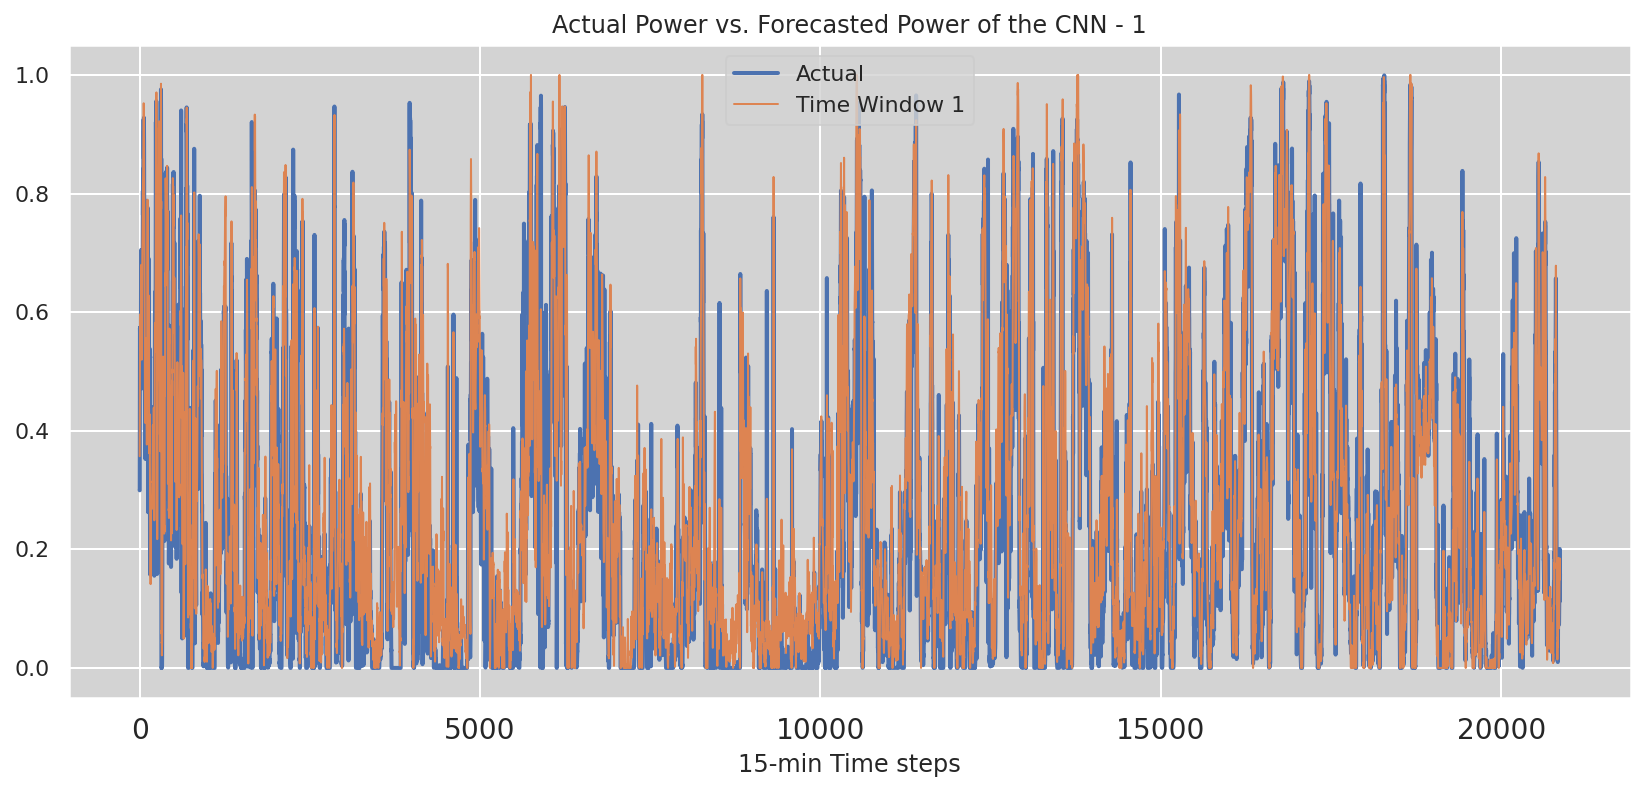

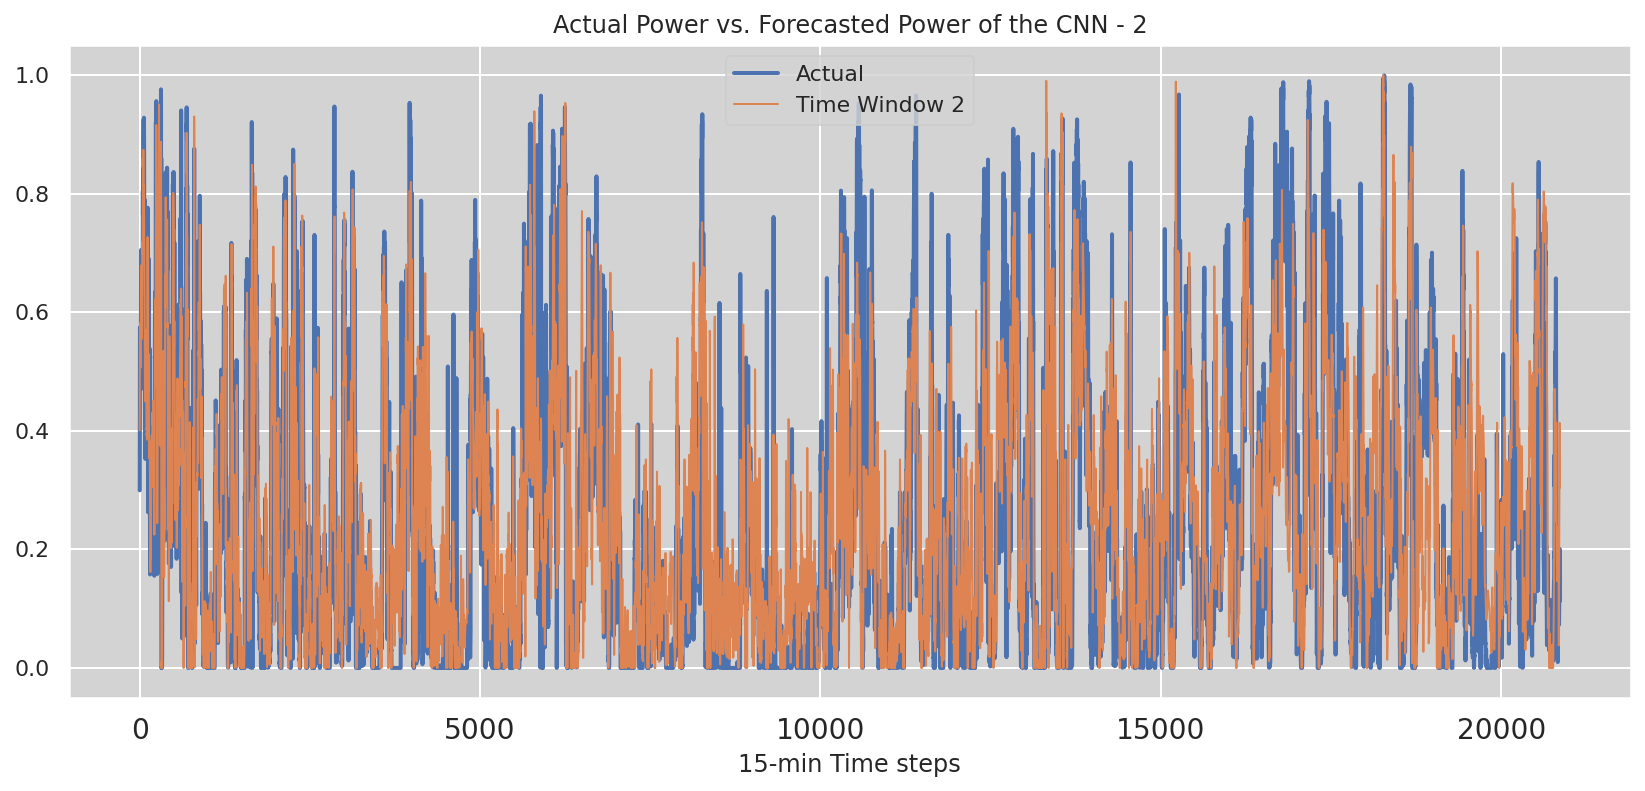

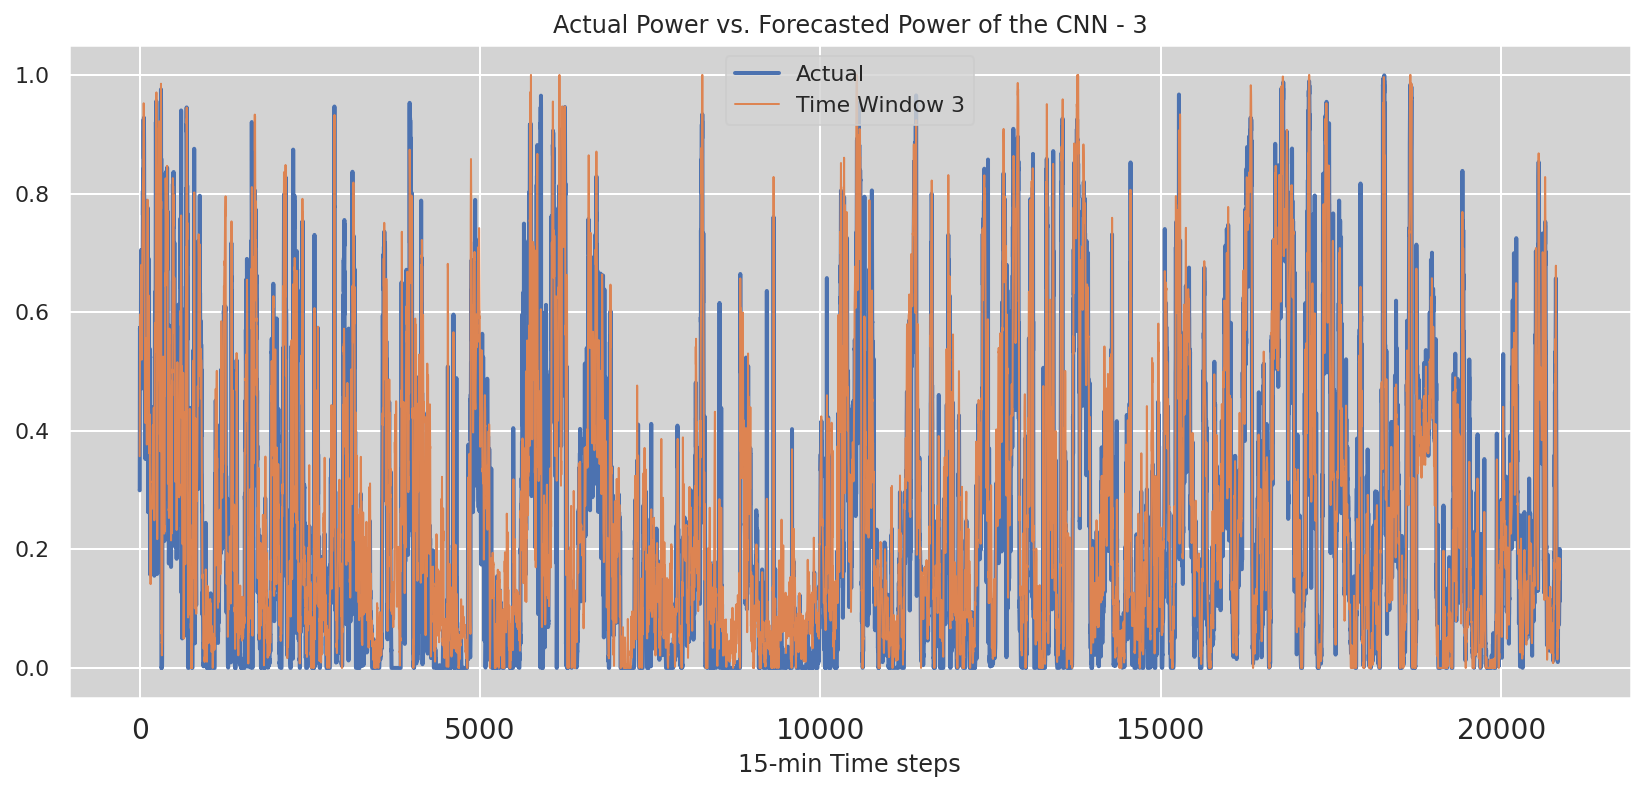

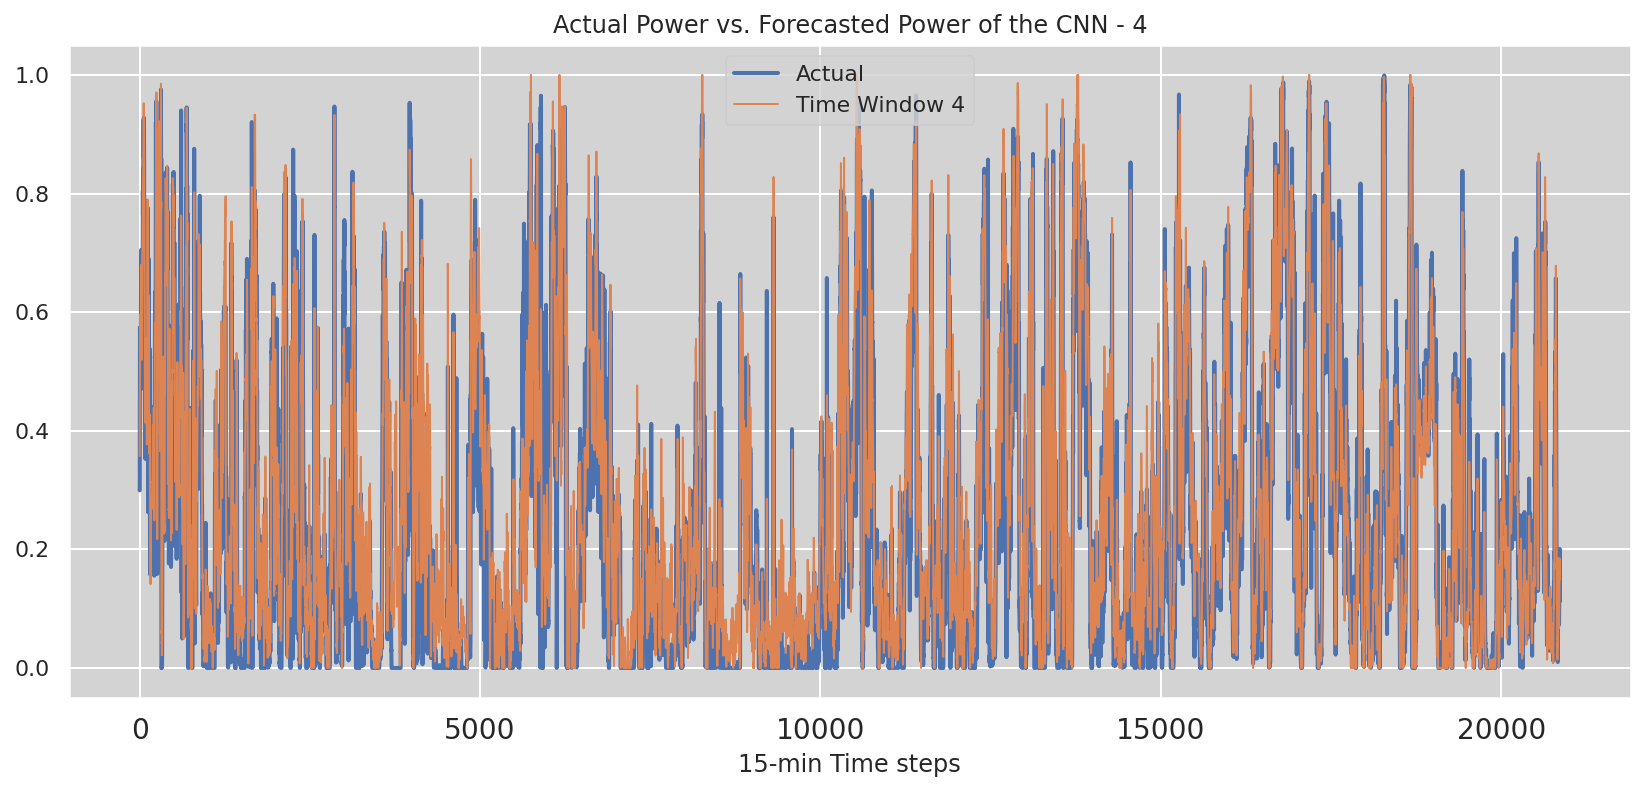

In [ ]:
# Plot of prediction for fold window size:
# variables: 'temp_target_flat' vs 'cnn_temp_flat1'
plt.figure(figsize=(14,6))
sns.lineplot(data= temp_target_flat, linewidth = 2, label = "Actual")
sns.lineplot(data=cnn_temp_flat1 , linewidth = 1, label = "Time Window 1")
# sns.lineplot(data=cnn_temp_flat2 , linewidth = 2, label = "Time Window 2")
# sns.lineplot(data=cnn_temp_flat3 , linewidth = 2, label = "Time Window 3")
# sns.lineplot(data=cnn_temp_flat4 , linewidth = 2, label = "Time Window 4")
# plt.title("Actual Power vs. Forecasted Power for the different time windows. Prediction by CNN")
plt.title("Actual Power vs. Forecasted Power of the CNN - 1")
plt.xlabel("15-min Time steps")
plt.xticks
plt.show()


# # Plot of prediction for 2 fold window size:
# # variables: 'temp_target_flat' vs 'cnn_temp_flat2'
plt.figure(figsize=(14,6))
sns.lineplot(data= temp_target_flat, linewidth = 2, label = "Actual")
sns.lineplot(data=cnn_temp_flat2 , linewidth = 1, label = "Time Window 2")
plt.title("Actual Power vs. Forecasted Power of the CNN - 2")
plt.xlabel("15-min Time steps")
plt.xticks
plt.show()


# # Plot of prediction for 3 fold window size:
# # variables: 'temp_target_flat' vs 'cnn_temp_flat3'
plt.figure(figsize=(14,6))
sns.lineplot(data= temp_target_flat, linewidth = 2, label = "Actual")
sns.lineplot(data=cnn_temp_flat3 , linewidth = 1, label = "Time Window 3")
plt.title("Actual Power vs. Forecasted Power of the CNN - 3")
plt.xlabel("15-min Time steps")
plt.xticks
plt.show()


# # Plot of prediction for 4 fold window size 8full window):
# # variables: 'temp_target_flat' vs 'cnn_temp_flat4'
plt.figure(figsize=(14,6))
sns.lineplot(data= temp_target_flat, linewidth = 2, label = "Actual")
sns.lineplot(data=cnn_temp_flat4 , linewidth = 1, label = "Time Window 4")
plt.title("Actual Power vs. Forecasted Power of the CNN - 4")
plt.xlabel("15-min Time steps")
plt.xticks
plt.show()

Plots of the error by batch for each window:

In [ ]:
len(err_test_1)

1305

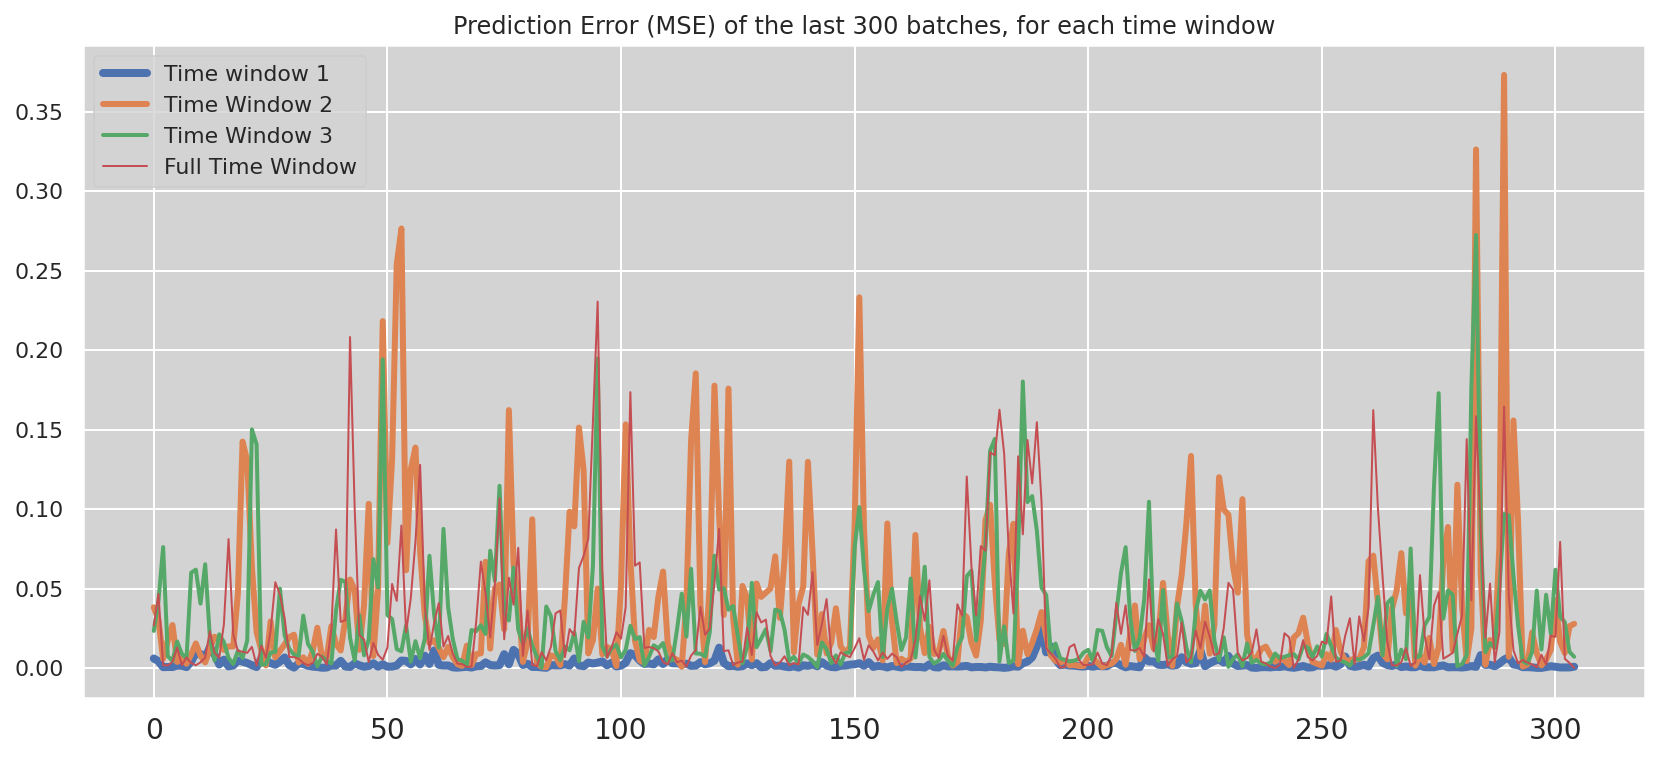

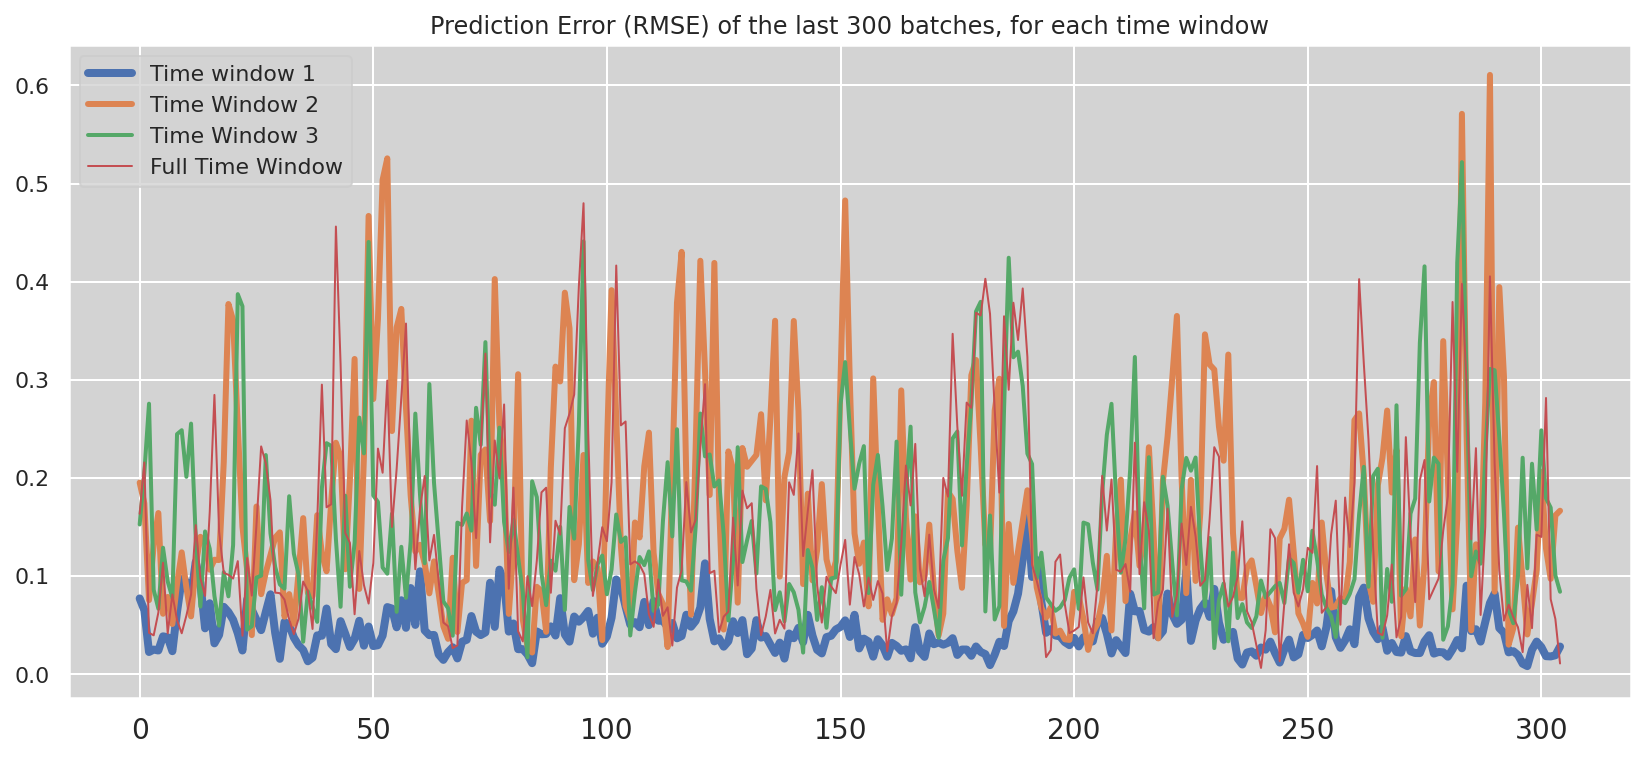

In [ ]:
# Plot of error by batch. Limited to last 300 batches
# # variables: 'temp_target_flat' vs 'cnn_temp_flat2'
plt.figure(figsize=(14,6))
sns.lineplot(data= err_test_1[1000:], linewidth = 4, label = "Time window 1")
sns.lineplot(data=err_test_2[1000:] , linewidth = 3, label = "Time Window 2")
sns.lineplot(data=err_test_3[1000:] , linewidth = 2, label = "Time Window 3")
sns.lineplot(data=err_test_4[1000:] , linewidth = 1, label = "Full Time Window")
plt.title("Prediction Error (MSE) of the last 300 batches, for each time window - CNN")
plt.xticks
plt.show()

plt.figure(figsize=(14,6))
sns.lineplot(data= rmse_test_1[1000:], linewidth = 4, label = "Time window 1")
sns.lineplot(data=rmse_test_2[1000:] , linewidth = 3, label = "Time Window 2")
sns.lineplot(data=rmse_test_3[1000:] , linewidth = 2, label = "Time Window 3")
sns.lineplot(data=rmse_test_4[1000:] , linewidth = 1, label = "Full Time Window")
plt.title("Prediction Error (RMSE) of the last 300 batches, for each time window - CNN")
plt.xticks
plt.show()

# K-Fold Cross Validation Temporal for LSTM

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Start low for troubleshooting purposes
num_epochs =250
batch_size = 508

window_size = []
err_test_lstm = []

win_len = 5000
for jj in range(1, 19):
    window_size.append(win_len)
    win_len = win_len + 5000

idx_ini_test = 93895
test_idx = np.arange(idx_ini_test, 104327)

for ii in window_size:
    train_idx = np.arange(idx_ini_test - ii, idx_ini_test)

    train_sampler = torch.utils.data.sampler.SequentialSampler(train_idx)
    test_sampler = torch.utils.data.sampler.SequentialSampler(test_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # Model:
    input_size = 4
    hidden_size = 32
    num_layers = 1
    num_classes = 1

    # Create NN:
    lstm_model = LSTM(num_classes, input_size, hidden_size, num_layers).cuda()
    lstm_model.apply(reset_weights)

    # Loss Function:
    criterion = torch.nn.MSELoss(reduction='none')
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0001)

    for epoch in range(num_epochs):
        train_error_epoch = train_epoch_cuda(lstm_model,device,train_loader,criterion,optimizer)
        print("Epoch:{}/{} AVG Training Loss:{:.3f}".format(epoch + 1, num_epoch, np.mean(train_error_epoch)))

    err_test_epoch_lstm = []
    lstm_model.eval()
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.type(torch.FloatTensor).cuda(), labels.type(torch.FloatTensor).cuda()
        output = lstm_model(inputs) # forward + backward + optimize
        batch_loss = criterion(torch.transpose(output, 0, 1), labels)
        batch_loss = torch.mean(batch_loss)
        err_test_epoch_lstm.append(batch_loss.data.cpu().detach().numpy())  # test error
    err_test_lstm.append(np.mean(err_test_epoch))
        

Epoch:1/5 AVG Training Loss:0.161
Epoch:2/5 AVG Training Loss:0.151
Epoch:3/5 AVG Training Loss:0.144
Epoch:4/5 AVG Training Loss:0.136
Epoch:5/5 AVG Training Loss:0.129
Epoch:1/5 AVG Training Loss:0.060
Epoch:2/5 AVG Training Loss:0.059
Epoch:3/5 AVG Training Loss:0.057
Epoch:4/5 AVG Training Loss:0.056
Epoch:5/5 AVG Training Loss:0.056


Error for each of the window sizes:

In [ ]:
print('Error for 1 fold window size:')
print(np.mean(err_test_1))
print('Error for 2 fold window size:')
print(np.mean(err_test_2))
print('Error for 3 fold window size:')
print(np.mean(err_test_3))
print('Error for 4 fold window size (full window):')
print(np.mean(err_test_4))

print('RMSE for 1 fold window size:')
print(np.mean(np.sqrt(err_test_1)))
print('RMSE for 2 fold window size:')
print(np.mean(np.sqrt(err_test_2)))
print('RMSE for 3 fold window size:')
print(np.mean(np.sqrt(err_test_3)))
print('RMSE for 4 fold window size (full window):')
print(np.mean(np.sqrt(err_test_4)))

Plots of the predictions for each window size:

In [ ]:
##############################################################
########     Extract actual Power, predicted Power    ########
##############################################################

# Extract target and call it "temp_target_flat": Temporal target labels, flat format
lstm_actual_temp =[]
for i in(target_temp_LSTM):
  lstm_actual_temp.append(i.detach().numpy().tolist())
temp_target_flat = [item for sublist in lstm_actual_temp for item in sublist]
print("Length of target: " + str(len(temp_target_flat)))

# Extract prediction of Time windows in flat format naming them "cnn_temp_flat{time_window}":
# CNN architecture for temporal predictions in flat format for time window {time window}

lstm_temp_pred1 = []
for i in(prediction_temp_LSTM_1):
  lstm_temp_pred1.append(i.detach().numpy().tolist())
lstm_temp_flat1 = []
for sublist in lstm_temp_pred1:
    for item in sublist:
        lstm_temp_flat1.extend(item)
lstm_temp_flat1 = np.array(lstm_temp_flat1)
lstm_temp_flat1 = np.clip(lstm_temp_flat1, 0,1)
lstm_temp_flat1=lstm_temp_flat1.flatten().tolist()
print("Length of pred1: " + str(len(lstm_temp_flat1)))

lstm_temp_pred2 =[]
for i in(prediction_temp_LSTM_2):
  lstm_temp_pred2.append(i.detach().numpy().tolist())
lstm_temp_flat2 = []
  for sublist in lstm_temp_pred2:
    for item in sublist:
        lstm_temp_flat2.extend(item)
lstm_temp_flat2 = np.array(lstm_temp_flat2)
lstm_temp_flat2 = np.clip(lstm_temp_flat2, 0,1)
lstm_temp_flat2=lstm_temp_flat2.flatten().tolist()
print("Length of pred2: " + str(len(lstm_temp_flat2)))

lstm_temp_pred3 =[]
for i in(prediction_temp_LSTM_3):
  lstm_temp_pred3.append(i.detach().numpy().tolist())
lstm_temp_flat3 = []
for sublist in lstm_temp_pred1:
    for item in sublist:
        lstm_temp_flat3.extend(item)
lstm_temp_flat1 = np.array(lstm_temp_flat1)
lstm_temp_flat1 = np.clip(lstm_temp_flat1, 0,1)
lstm_temp_flat1=lstm_temp_flat1.flatten().tolist()
print("Length of pred3: " + str(len(lstm_temp_flat3)))

lstm_temp_pred4 =[]
for i in(prediction_temp_LSTM_4):
  lstm_temp_pred4.append(i.detach().numpy().tolist())
lstm_temp_flat4 = []
for sublist in lstm_temp_pred1:
    for item in sublist:
        lstm_temp_flat4.extend(item)
lstm_temp_flat4 = np.array(lstm_temp_flat4)
lstm_temp_flat4 = np.clip(lstm_temp_flat4, 0,1)
lstm_temp_flat4=lstm_temp_flat4.flatten().tolist()
print("Length of pred4: " + str(len(lstm_temp_flat4)))

Length of target: 20866
Length of pred1: 20866
Length of pred2: 20866
Length of pred3: 20866
Length of pred4: 20866


In [ ]:
# Dar formato a errores para poder plotear

err_test_1 = [item.item() for item in err_test_1]
err_test_2 = [item.item() for item in err_test_2]
err_test_3 = [item.item() for item in err_test_3]
err_test_4 = [item.item() for item in err_test_4]


rmse_test_1 = np.sqrt(err_test_1)
rmse_test_2 = np.sqrt(err_test_2)
rmse_test_3 = np.sqrt(err_test_3)
rmse_test_4 = np.sqrt(err_test_4)

In [ ]:
# Plot of prediction for fold window size:
# variables: 'temp_target_flat' vs 'cnn_temp_flat1'
plt.figure(figsize=(14,6))
sns.lineplot(data= temp_target_flat, linewidth = 2, label = "Actual")
sns.lineplot(data=lstm_temp_flat1 , linewidth = 1, label = "Time Window 1")
plt.title("Actual Power vs. Forecasted Power of the LSTM - 1")
plt.xlabel("15-min Time steps")
plt.xticks
plt.show()


# # Plot of prediction for 2 fold window size:
# # variables: 'temp_target_flat' vs 'cnn_temp_flat2'
plt.figure(figsize=(14,6))
sns.lineplot(data= temp_target_flat, linewidth = 2, label = "Actual")
sns.lineplot(data=lstm_temp_flat2 , linewidth = 1, label = "Time Window 2")
plt.title("Actual Power vs. Forecasted Power of the LSTM - 2")
plt.xlabel("Number of epochs")
plt.xticks
plt.show()


# # Plot of prediction for 3 fold window size:
# # variables: 'temp_target_flat' vs 'cnn_temp_flat3'
plt.figure(figsize=(14,6))
sns.lineplot(data= temp_target_flat, linewidth = 2, label = "Actual")
sns.lineplot(data=lstm_temp_flat3 , linewidth = 1, label = "Time Window 3")
plt.title("Actual Power vs. Forecasted Power of the LSTM - 3")
plt.xlabel("15-min Time steps")
plt.xticks
plt.show()


# # Plot of prediction for 4 fold window size 8full window):
# # variables: 'temp_target_flat' vs 'cnn_temp_flat4'
plt.figure(figsize=(14,6))
sns.lineplot(data= temp_target_flat, linewidth = 2, label = "Actual")
sns.lineplot(data=lstm_temp_flat4 , linewidth = 1, label = "Time Window 4")
plt.title("Actual Power vs. Forecasted Power of the LSTM - 4")
plt.xlabel("15-min Time steps")
plt.xticks
plt.show()

Plots de los errores (MSE y RMSE) por batch (limitado a los ultimos 300) por cada time window

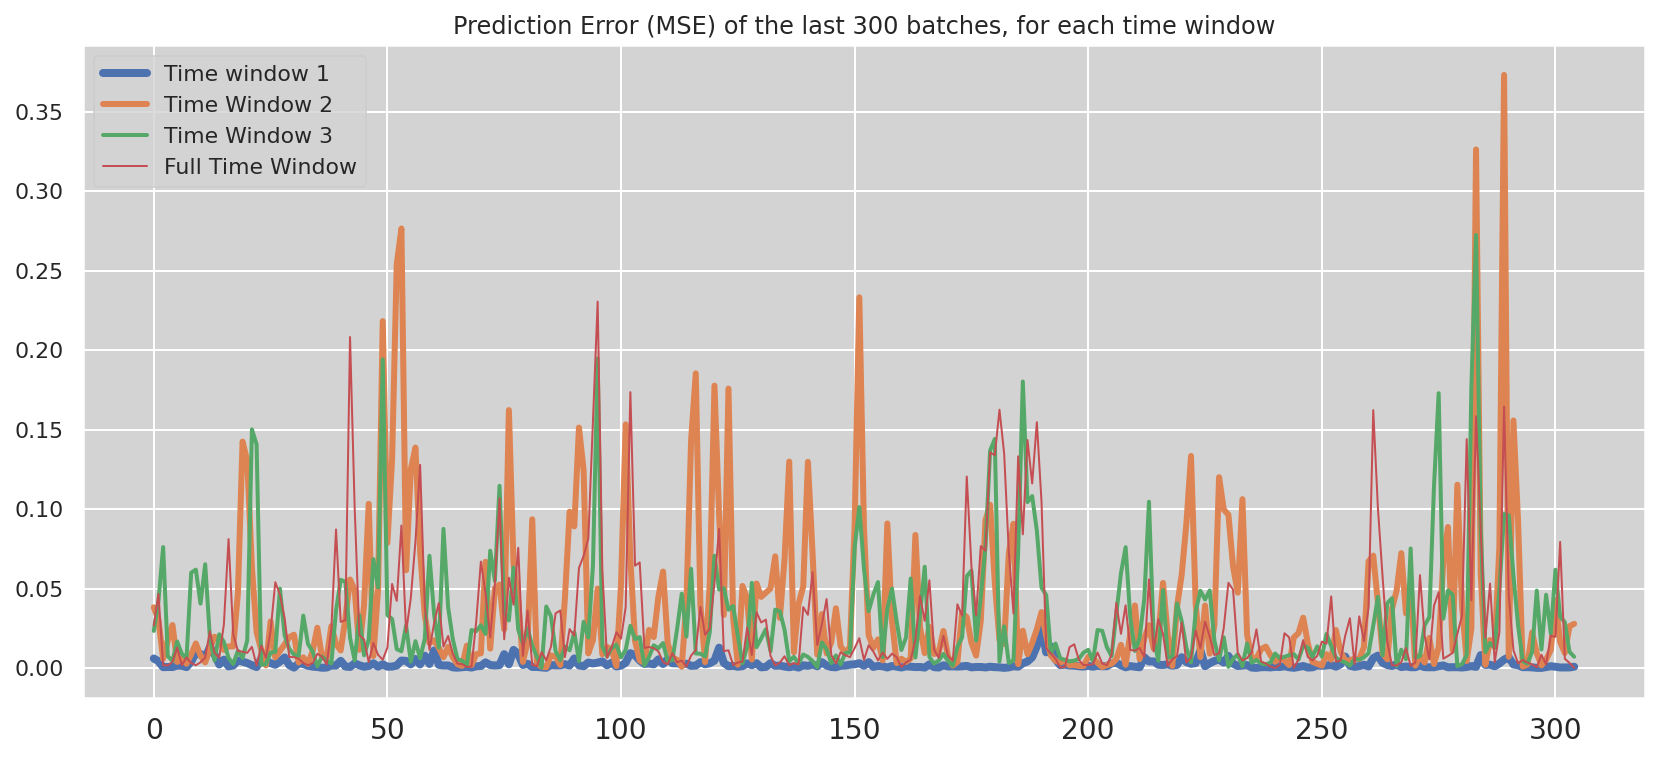

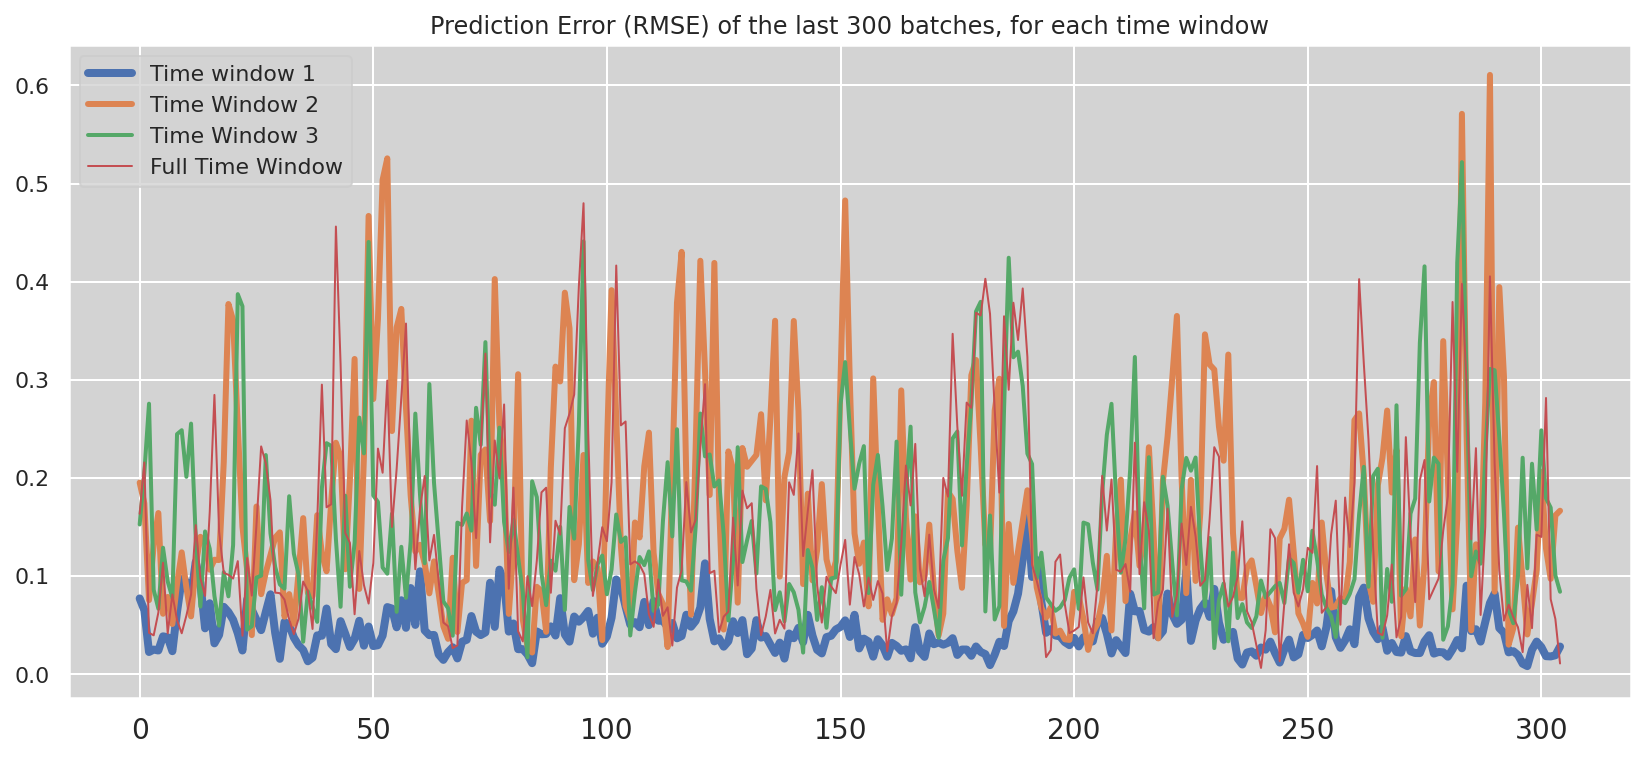

In [ ]:
# Plot of error by batch. Limited to last 300 batches
# # variables: 'temp_target_flat' vs 'cnn_temp_flat2'
plt.figure(figsize=(14,6))
sns.lineplot(data= err_test_1[1000:], linewidth = 4, label = "Time window 1")
sns.lineplot(data=err_test_2[1000:] , linewidth = 3, label = "Time Window 2")
sns.lineplot(data=err_test_3[1000:] , linewidth = 2, label = "Time Window 3")
sns.lineplot(data=err_test_4[1000:] , linewidth = 1, label = "Full Time Window")
plt.title("Prediction Error (MSE) of the last 300 batches, for each time window - CNN")
plt.xticks
plt.show()

plt.figure(figsize=(14,6))
sns.lineplot(data= rmse_test_1[1000:], linewidth = 4, label = "Time window 1")
sns.lineplot(data=rmse_test_2[1000:] , linewidth = 3, label = "Time Window 2")
sns.lineplot(data=rmse_test_3[1000:] , linewidth = 2, label = "Time Window 3")
sns.lineplot(data=rmse_test_4[1000:] , linewidth = 1, label = "Full Time Window")
plt.title("Prediction Error (RMSE) of the last 300 batches, for each time window - CNN")
plt.xticks
plt.show()

# Appendix: CNN Architecture


In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=8c491947e93823b2f79c23b0c83ab82b9d1ba8f0285955bf4f47b65a5c8738f1
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
from torchviz import make_dot

In [ ]:
make_dot(output, params=dict(model.named_parameters()), show_attrs=True).render("Complete CNN Architecture", format="png")